# Project 6: IMDb Top 250 Movies

In [1]:
from IPython.core.display import Image
from matplotlib.patches import Polygon
from imdbpie import Imdb
import pandas as pd
import plotly as pt
from matplotlib import pyplot as plt
import numpy as np
from sklearn import cross_validation, preprocessing
from sklearn.preprocessing import MinMaxScaler
import time
import requests
import bs4
from bs4 import BeautifulSoup
import cPickle
import seaborn as sns
import re
from matplotlib import cm
from matplotlib.colors import ColorConverter
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.cross_validation import train_test_split
import matplotlib.patheffects as path_effects


% matplotlib inline

In [2]:
Image(url='http://bit.ly/29OUgDA', width = 650)

In this notebook, we'll investigate which features are significant in predicting user rating of the top 250 movies on IMDb.  But wait!  NB Any cells that are commented out do not need to be run.  Files/corrections/etc pertaining to them will load in subsequent cells.  Thanks!

Get Top 250 movies, save to file:

In [3]:
# imdb = Imdb()
# imdb = Imdb(anonymize=True)
# imdb = Imdb(cache=True)
# top = imdb.top_250()

In [4]:
# top = pd.DataFrame(top)
# top.to_csv('/Users/Rebecca/DSI-projects/projects/project-06/assets/top.csv', index = False, encoding = 'utf-8')
# len(top)

Load Top 250 movie data from file:

In [5]:
top = pd.read_csv('/Users/Rebecca/DSI-projects/projects/project-06/assets/top.csv')

In [6]:
top.head(2)

,can_rate,image,num_votes,rating,tconst,title,type,year
0,True,{u'url': u'http://ia.media-imdb.com/images/M/M...,1680129,9.3,tt0111161,The Shawshank Redemption,feature,1994
1,True,{u'url': u'http://ia.media-imdb.com/images/M/M...,1149482,9.2,tt0068646,The Godfather,feature,1972


In [7]:
top.dtypes

can_rate        bool
image         object
num_votes      int64
rating       float64
tconst        object
title         object
type          object
year           int64
dtype: object

In [8]:
top['image'][0]

"{u'url': u'http://ia.media-imdb.com/images/M/MV5BODU4MjU4NjIwNl5BMl5BanBnXkFtZTgwMDU2MjEyMDE@._V1_.jpg', u'width': 933, u'height': 1388}"

In [9]:
del top['image']

In [10]:
top['can_rate'].value_counts()

True    250
Name: can_rate, dtype: int64

In [11]:
del top['can_rate']

In [12]:
top['type'].value_counts()

feature    250
Name: type, dtype: int64

In [13]:
del top['type']

In [14]:
top = top[['tconst', 'title', 'rating', 'num_votes', 'year']]

In [15]:
top['year'] = top['year'].apply(lambda x: int(x))

In [16]:
top['num_votes'].describe()

count    2.500000e+02
mean     4.034077e+05
std      3.310935e+05
min      2.509900e+04
25%      1.229165e+05
50%      3.236250e+05
75%      5.948370e+05
max      1.680129e+06
Name: num_votes, dtype: float64

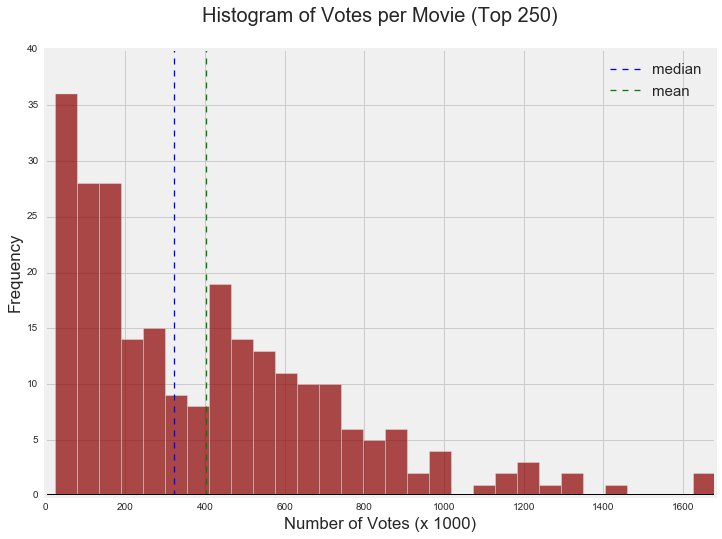

In [17]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

df_hist = plt.hist(top['num_votes']/1000, color = 'darkred', bins = 30, alpha = 0.7)
plt.axvline(top['num_votes'].median()/1000, color='b', linestyle='dashed', linewidth=1.3, label = 'median')
plt.axvline(top['num_votes'].mean()/1000, color='g', linestyle='dashed', linewidth=1.3, label = 'mean')
plt.axhline(0, color='black')
plt.title('Histogram of Votes per Movie (Top 250)', fontsize = 20, y = 1.05)

# y label
plt.ylabel('Frequency')

# x label
plt.xlabel('Number of Votes (x 1000)')

plt.xlim([0, max(top['num_votes']/1000)])
plt.ylim([0, 40])

plt.legend(loc='upper right', fontsize = 15)

plt.show()

Looks like it could be the upper portion of a normal curve; unclear what is going on in that dip around 400,000, however.

Which movies have more than a million votes?  Hmmmm, seems unlikely the movie with the most votes would be index 0 in the list by accident...

In [18]:
top[top['num_votes'] > 1000000][['title', 'year', 'num_votes']].sort('num_votes', ascending = False)

/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning:

sort(columns=....) is deprecated, use sort_values(by=.....)



,title,year,num_votes
0,The Shawshank Redemption,1994,1680129
3,The Dark Knight,2008,1665144
13,Inception,2010,1458647
9,Fight Club,1999,1339026
6,Pulp Fiction,1994,1316868
12,Forrest Gump,1994,1242614
10,The Lord of the Rings: The Fellowship of the Ring,2001,1232102
17,The Matrix,1999,1210771
7,The Lord of the Rings: The Return of the King,2003,1208872
1,The Godfather,1972,1149482


Which five movies have the least number of votes?

In [19]:
top.sort('num_votes').head(5)[['title', 'year', 'num_votes']].sort('num_votes')

/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning:

sort(columns=....) is deprecated, use sort_values(by=.....)



,title,year,num_votes
164,Come and See,1985,25099
174,Nights of Cabiria,1957,25670
225,Kind Hearts and Coronets,1949,26017
147,Tokyo Story,1953,26188
115,Children of Heaven,1997,27215


In [20]:
top['rating'].describe()

count    250.000000
mean       8.315200
std        0.231133
min        8.000000
25%        8.100000
50%        8.300000
75%        8.400000
max        9.300000
Name: rating, dtype: float64

Remember: minimum rating is so high because we're only looking at top 250 movies!

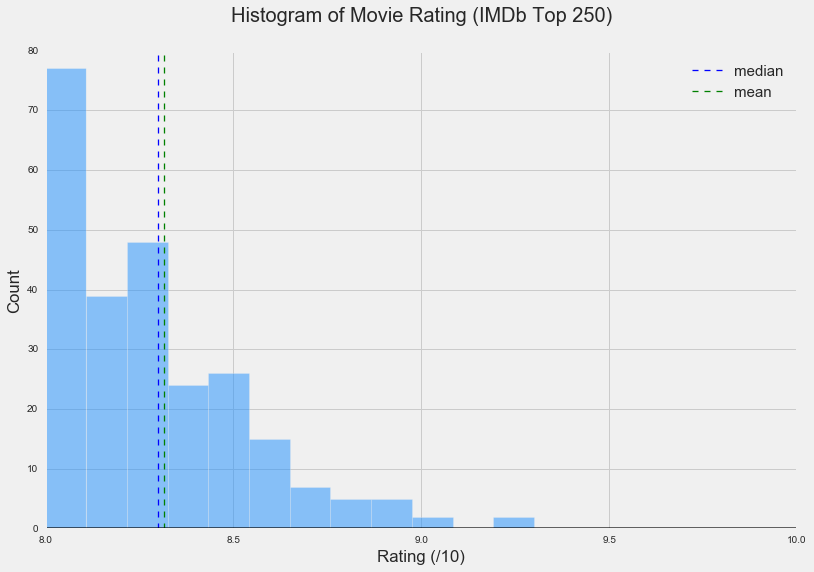

In [21]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

df_hist = plt.hist(top['rating'], color = 'dodgerblue', alpha = 0.5, bins = 12)
plt.axvline(top['rating'].median(), color='b', linestyle='dashed', linewidth=1.3, label = 'median')
plt.axvline(top['rating'].mean(), color='g', linestyle='dashed', linewidth=1.3, label = 'mean')
plt.axhline(0, color='black', alpha = 0.6)
plt.title('Histogram of Movie Rating (IMDb Top 250)', fontsize = 20, y = 1.05)

# y label
plt.ylabel('Count')

# x label
plt.xlabel('Rating (/10)')

plt.xlim([min(top['rating']), 10])
#plt.ylim([-10, 85])

plt.legend(loc='upper right', fontsize = 15)

plt.show()

Is index number random?  Very clearly not, from this plot of index number vs. user rating: 

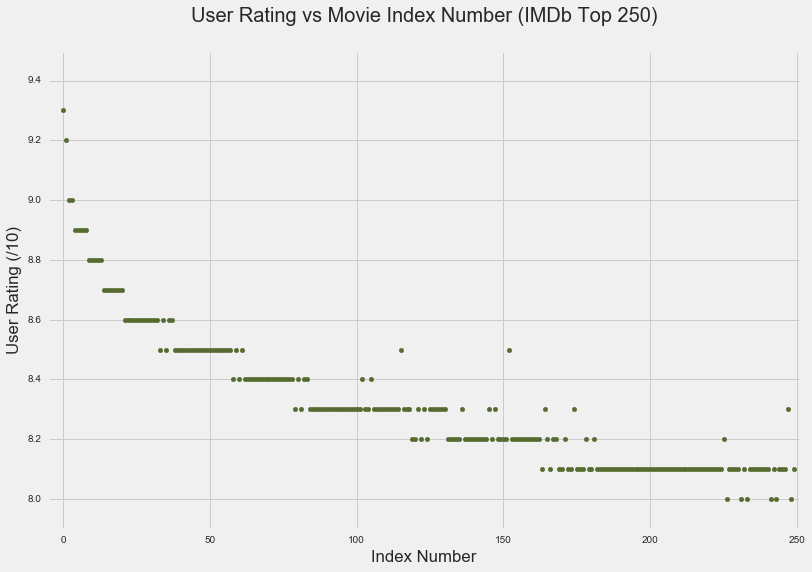

In [22]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

plt.scatter(top.index, top['rating'], color = 'DarkOliveGreen')
plt.axhline(0, color='black', alpha = 0.6)
plt.title('User Rating vs Movie Index Number (IMDb Top 250)', fontsize = 20, y = 1.05)

# y label
plt.ylabel('User Rating (/10)')

# x label
plt.xlabel('Index Number', y = 0.1)

plt.xlim([-5, len(top) + 1])
plt.ylim([7.9, 9.5])


plt.show()

What's up with those outliers?  Looks like it should be nearly non-overlapping steps in negative direction from index 0 to index 249.  We'll consider taking these out of the data set because they are clearly exceptions to the general trend of user rating being negatively correlated with index number.  Let's look at some boxplots to check outlier-ness:

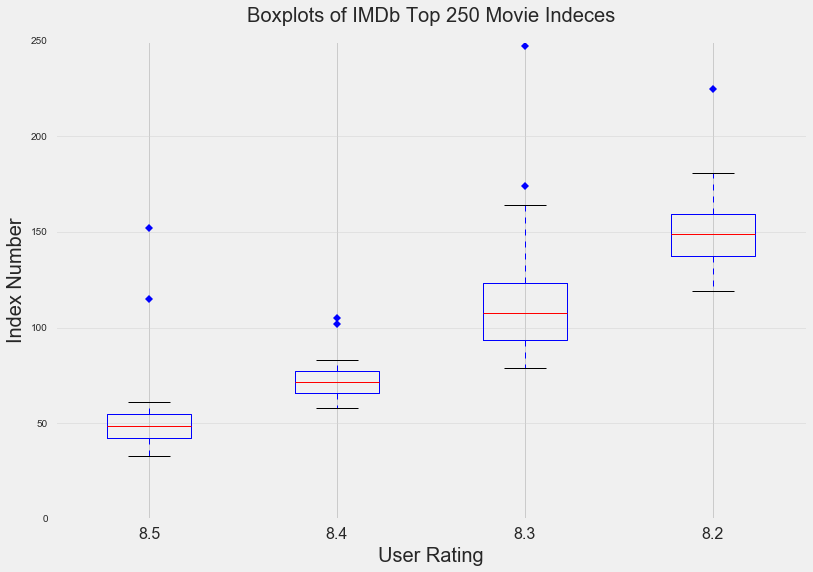

In [23]:
data = [top[top['rating'] == 8.5].index, top[top['rating'] == 8.4].index, \
        top[top['rating'] == 8.3].index, top[top['rating'] == 8.2].index]
plt.style.use('fivethirtyeight')
fig, ax1 = plt.subplots(figsize=(12, 8))
fig.canvas.set_window_title('Boxplots of Several IMDb Top 250 User Ratings')
plt.subplots_adjust(\
#                    left=0.075, right=0.95, top=0.9, bottom=0.25\
                   )

bp = plt.boxplot(data, 0, 'gD')

ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)

ax1.set_axisbelow(True)
ax1.set_title('Boxplots of IMDb Top 250 Movie Indeces', y =1.03)
ax1.set_xlabel('User Rating', fontsize = 20)
ax1.set_ylabel('Index Number', fontsize = 20)

# Set the axes ranges and axes labels
numBoxes = 4
ax1.set_xlim(0.5, numBoxes + 0.5)
#ax1.set_ylim(425, 625)
xtickNames = plt.setp(ax1, xticklabels=['8.5', '8.4', '8.3', '8.2'])
plt.setp(xtickNames, fontsize=16)

plt.show()

Which movies are these?  We'll take them out of the dataset, but let's see what they are first:

In [24]:
top[(top['rating'] == 8.5) & (top.index > 100)][['title', 'year', 'rating']]

,title,year,rating
115,Children of Heaven,1997,8.5
152,The Message,1976,8.5


In [25]:
top[(top['rating'] == 8.4) & (top.index > 95)][['title', 'year', 'rating']] 

,title,year,rating
102,A Separation,2011,8.4
105,3 Idiots,2009,8.4


In [26]:
top[(top['rating'] == 8.3) & (top.index > 150)][['title', 'year', 'rating']]

,title,year,rating
164,Come and See,1985,8.3
174,Nights of Cabiria,1957,8.3
247,Gangs of Wasseypur,2012,8.3


In [27]:
top[(top['rating'] == 8.2)][['title', 'year', 'rating']].tail(1)                                                              

,title,year,rating
225,Kind Hearts and Coronets,1949,8.2


Hm, seems like we ought to remove these because the box and whisker plots suggest they are true outliers.  We'll keep them in for now and remove them after a little more exploratory data analysis.

In [28]:
top['year'].describe()

count     250.000000
mean     1984.028000
std        24.152361
min      1921.000000
25%      1964.000000
50%      1991.000000
75%      2003.750000
max      2016.000000
Name: year, dtype: float64

In the histogram below, each bar slot represents one year:

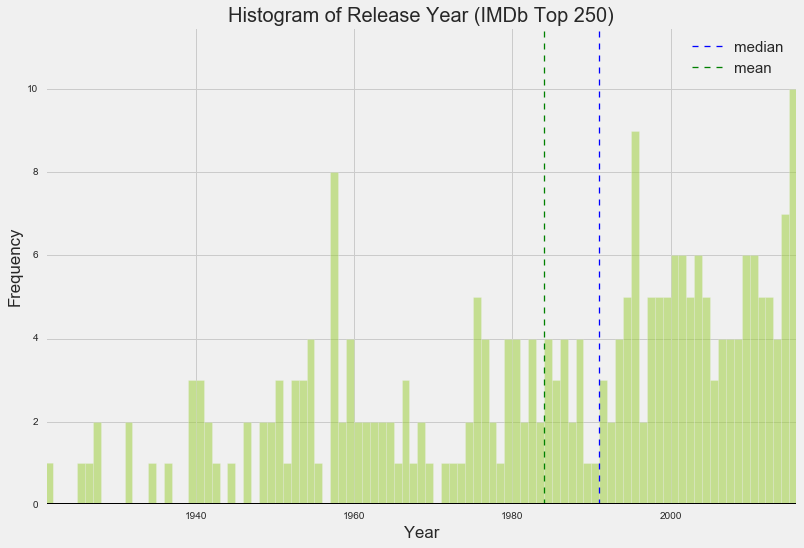

In [29]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

df_hist = plt.hist(top['year'], color = 'yellowgreen', alpha = 0.5, bins = 95)
plt.axvline(top['year'].median(), color='b', linestyle='dashed', linewidth=1.3, label = 'median')
plt.axvline(top['year'].mean(), color='g', linestyle='dashed', linewidth=1.3, label = 'mean')
plt.axhline(0, color='black')
plt.title('Histogram of Release Year (IMDb Top 250)', fontsize = 20)

# y label
plt.ylabel('Frequency')

# x label
plt.xlabel('Year')

plt.xlim([min(top['year']), max(top['year'])])
plt.ylim([0, 11.5])

plt.legend(loc='upper right', fontsize = 15)

plt.show()

1957 was a good year:

In [30]:
top[top['year'] == 1957][['title', 'year', 'num_votes']].sort('num_votes', ascending = False)

/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning:

sort(columns=....) is deprecated, use sort_values(by=.....)



,title,year,num_votes
5,12 Angry Men,1957,444537
131,The Bridge on the River Kwai,1957,148511
56,Paths of Glory,1957,120296
134,The Seventh Seal,1957,111224
140,Wild Strawberries,1957,62751
71,Witness for the Prosecution,1957,62644
245,Throne of Blood,1957,31534
174,Nights of Cabiria,1957,25670


As was 1995:

In [31]:
top[top['year'] == 1995][['title', 'year', 'num_votes']].sort('num_votes', ascending = False)

/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning:

sort(columns=....) is deprecated, use sort_values(by=.....)



,title,year,num_votes
21,Se7en,1995,1017162
24,The Usual Suspects,1995,736650
75,Braveheart,1995,732761
91,Toy Story,1995,619286
219,Twelve Monkeys,1995,460419
122,Heat,1995,429218
138,Casino,1995,331585
205,Before Sunrise,1995,181895
227,La Haine,1995,102825


The spike farthest to the right on the histogram is combined 2015 and 2016-to-date:

In [32]:
top[(top['year'] == 2015) | (top['year'] == 2016)][['title', 'year']].sort('title')

/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning:

sort(columns=....) is deprecated, use sort_values(by=.....)



,title,year
160,Captain America: Civil War,2016
203,Deadpool,2016
118,Inside Out,2015
183,Mad Max: Fury Road,2015
123,Room,2015
180,Spotlight,2015
141,Star Wars: The Force Awakens,2015
232,The Martian,2015
213,The Revenant,2015
178,Zootopia,2016


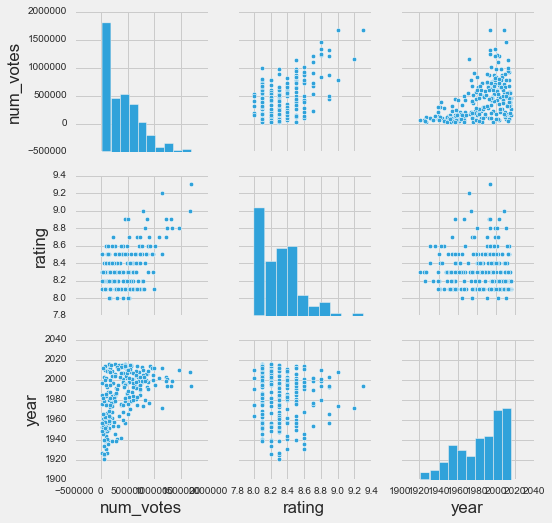

In [33]:
sns.pairplot(top[['num_votes', 'rating', 'year']])

Let's dig a little deeper into these plots...  

We'll use 'rating' to assign the area of points on a scatterplot of number of votes vs. year of movie release.  Let's try a range in area from 10 to 300:

In [34]:
rating_area = []
for rating in top['rating']:
    new_rating = (((300 - 10)*(rating - min(top['rating']))) / (max(top['rating'] - min(top['rating'])))) + 10
    rating_area.append(new_rating)

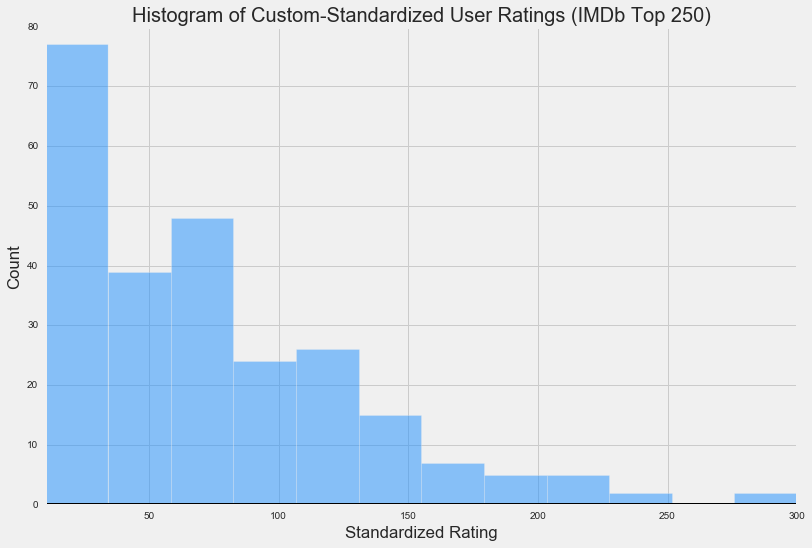

In [35]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

df_hist = plt.hist(rating_area, color = 'dodgerblue', alpha = 0.5, bins = 12)
plt.axhline(0, color='black')
plt.title('Histogram of Custom-Standardized User Ratings (IMDb Top 250)', fontsize = 20)

# y label
plt.ylabel('Count')

# x label
plt.xlabel('Standardized Rating')

plt.xlim([min(rating_area), max(rating_area)])

plt.show()

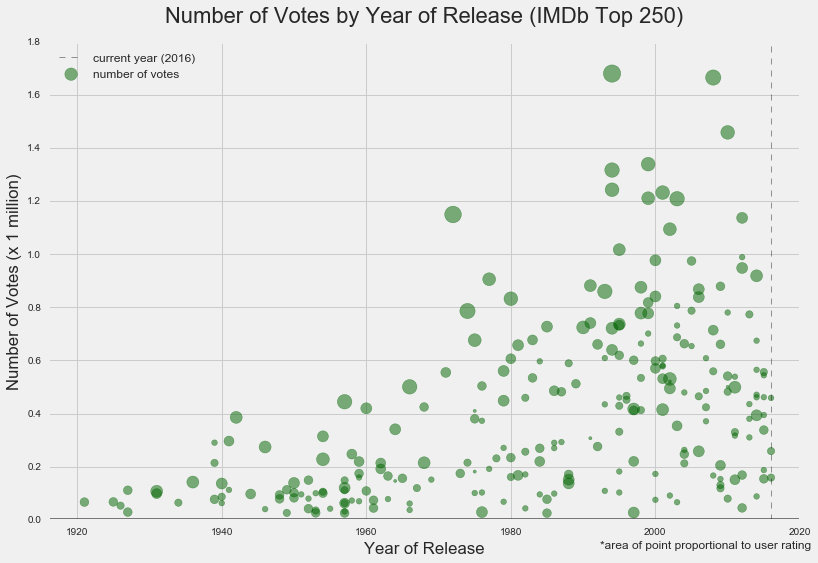

In [36]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

plt.scatter(top['year'], top['num_votes']/1000000, color = 'darkgreen', alpha = 0.5, s = rating_area, \
            label = 'number of votes')

plt.title('Number of Votes by Year of Release (IMDb Top 250)', fontsize = 22, y = 1.03)
plt.axhline(0, color='black', alpha = 0.5)
plt.axvline(2016, color='black', linestyle='dashed', alpha = 0.5, linewidth=0.8, label = 'current year (2016)')

# y label
plt.ylabel('Number of Votes (x 1 million)')

# x label
plt.xlabel('Year of Release')

# set the figure boundaries
plt.xlim([min(top['year'])-5, 2020])
plt.ylim([0, 1.80])
plt.grid(True)
plt.legend(loc='upper left', fontsize = 12)
plt.annotate('*area of point proportional to user rating', (1,0), (-200, -20), \
             xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 12)
plt.show()

Let's create a list of areas with respect to year of release, as well, just to have in our pocket:

In [37]:
year_area = []
for year in top['year']:
    new_year = (((100 - 5)*(year - min(top['year'])) ) / (max(top['year'] - min(top['year'])))) + 5
    year_area.append(new_year)

The plot below suggests that the more votes a movie has, the higher its rating will be.  We see that older movies tend to have fewer votes.  Also, the spread in older movies' ratings is smaller and the average rating appears lower. 

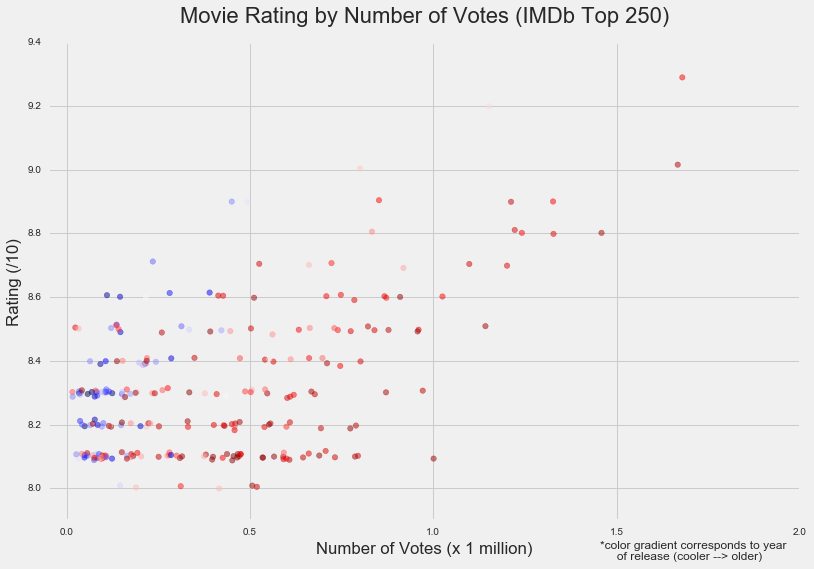

In [38]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

top_year_color = []
count = 0
for i in top['year']:
    lil_color = cm.seismic((i-1920)*256/(2017-1920))
    top_year_color.append(lil_color)
    
top['top_year_color'] = top_year_color

def rand_jitter(arr):
    stdev = .005*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

def jitter(x, y, s=30, marker='o', cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, \
           verts=None, hold=None, **kwargs):
    return plt.scatter(rand_jitter(x), rand_jitter(y), s=s, marker=marker, cmap=cmap, norm=norm, vmin=vmin, \
                       vmax=vmax, alpha=0.5, linewidths=linewidths, verts=verts, hold=hold, **kwargs)

jitter(top['num_votes']/1000000, top['rating'], color = top['top_year_color'], alpha = 0.55)


plt.title('Movie Rating by Number of Votes (IMDb Top 250)', fontsize = 22, y = 1.03)
plt.axhline(0, color='darkblue', alpha = 0.5)
# y label
plt.ylabel('Rating (/10)')

# x label
plt.xlabel('Number of Votes (x 1 million)')

# set the figure boundaries
plt.xlim([-0.05, 2])
plt.ylim([7.9, 9.4])
plt.grid(True)

plt.annotate('*color gradient corresponds to year \n     of release (cooler --> older)', (1,0), (-200, -20), \
             xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 12)
plt.show()

## jitter assistance from:
## http://stackoverflow.com/questions/8671808/matplotlib-avoiding-overlapping-datapoints-in-a-scatter-dot-beeswarm-plot

In [39]:
top[(top['rating'] > 8.8) & (top['num_votes'] > 1250000)][['title', 'year', 'num_votes', 'rating']]

,title,year,num_votes,rating
0,The Shawshank Redemption,1994,1680129,9.3
3,The Dark Knight,2008,1665144,9.0
6,Pulp Fiction,1994,1316868,8.9


Let's use an API to get what we can:

In [40]:
# certification = []
# for movie in top['tconst']:
#     time.sleep(0.25)
#     title = imdb.get_title_by_id(movie)
#     cert = title.certification
#     certification.append(cert)
# print 'done collecting!'
# certification = pd.DataFrame(certification)
# certification.to_csv('/Users/Rebecca/DSI-projects/projects/project-06/assets/certification.csv', index = False, \
# encoding = 'utf-8')

In [41]:
certification = pd.read_csv('/Users/Rebecca/DSI-projects/projects/project-06/assets/certification.csv')
certification.columns = ['cert']
top['cert'] = certification
top['cert'].value_counts()

R            92
Not Rated    33
PG           32
PG-13        30
Approved     14
Unrated      12
G            10
TV-PG         9
TV-14         6
TV-MA         4
Passed        3
M             2
X             1
TV-G          1
E             1
Name: cert, dtype: int64

Ew!  Let's consolidate.  This cell prints all movies not having 'R', 'PG-13', 'PG', or 'G' as a certification, which is a long list of which I checked every observation and updated:

In [42]:
# cert_OK = ['R', 'PG-13', 'PG', 'G']
# for i in range(len(top['cert'])):
#     if top['cert'][i] in cert_OK:
#         print '.',
#     else:
#         print '\n'
#         print top.loc[i][['title', 'cert']]

In [43]:
# top['cert'][101] = 'PG-13' # Indiana Jones and the Last Crusade
# top['cert'][91] = 'G' # Toy Story
# top['cert'][78] = 'R' # A Clockwork Orange
# top['cert'][34] = 'G' # City Lights
# top['cert'][80] = 'Not Rated' # Double Indemnity
# top['cert'][215] = 'G' # Wizard of Oz 
# top['cert'][27] = 'PG-13' # Once Upon a Time in the West
# top['cert'][241] = 'R' # A Fistful of Dollars
# top['cert'][9] = 'R' # Fight Club
# top['cert'][29] = 'R' # Saving Private Ryan
# top['cert'][74] = 'R' # Reservoir Dogs
# top['cert'][96] = 'R' # L.A. Confidential
# top['cert'][30] = 'R' # American History X
# top['cert'][40] = 'R' # Terminator 2: Judgment Day
# top['cert'][52] = 'R' # Alien
# top['cert'][64] = 'PG-13' # Princess Mononoke
# top['cert'][100] = 'R' # Scarface
# top['cert'][145] = 'Not Rated' # Judgment at Nuremberg
# top['cert'][18] = 'Not Rated' # Seven Samurai
# top['cert'][26] = 'R' # Léon: The Professional
# top['cert'][59] = 'Not Rated' # Grave of the Fireflies
# top['cert'][77] = 'R' # Requiem for a Dream
# top['cert'][99] = 'Not Rated' # Rashomon
# top['cert'][106] = 'Not Rated' # Yojimbo
# top['cert'][139] = 'Not Rated' # The General
# top['cert'][140] = 'Not Rated' # Wild Strawberries
# top['cert'][171] = 'Not Rated' # It Happened One Night
# top['cert'][209] = 'Not Rated' # Diabolique
# top['cert'][210] = 'Not Rated' # Memories of Murder
# top['cert'][245] = 'Not Rated' # Throne of Blood
# top['cert'][32] = 'PG' # Casablanca
# top['cert'][104] = 'Approved' # All About Eve
# top['cert'][109] = 'Not Rated' # The Treasure of the Sierra Madre
# top['cert'][137] = 'PG' # Howl's Moving Castle
# top['cert'][158] = 'G' # Gone With the Wind
# top['cert'][196] = 'G' # Ben-Hur
# top['cert'][216] = 'G' # Monsters, Inc.
# top['cert'][223] = 'PG' # Strangers on a Train
# top['cert'][242] = 'PG' # Castle in the Sky
# top['cert'][23] = 'PG' # It's a Wonderful Life
# top['cert'][33] = 'R' # Psycho
# top['cert'][39] = 'PG' # Rear Window
# top['cert'][50] = 'PG' # Dr. Strangelove
# top['cert'][70] = 'PG' # Vertigo
# top['cert'][131] = 'PG' # Bridge on the River Kwai

In [44]:
# certification = pd.DataFrame(top['cert'])
# certification.to_csv('/Users/Rebecca/DSI-projects/projects/project-06/assets/certification2.csv', index = False, \
#     encoding = 'utf-8')

In [45]:
certification = pd.read_csv('/Users/Rebecca/DSI-projects/projects/project-06/assets/certification2.csv')
certification.columns = ['cert']
top['cert'] = certification

Muuuch nicer:

In [46]:
top['cert'].value_counts()

R            105
Not Rated     46
PG            41
PG-13         33
G             16
Approved       9
Name: cert, dtype: int64

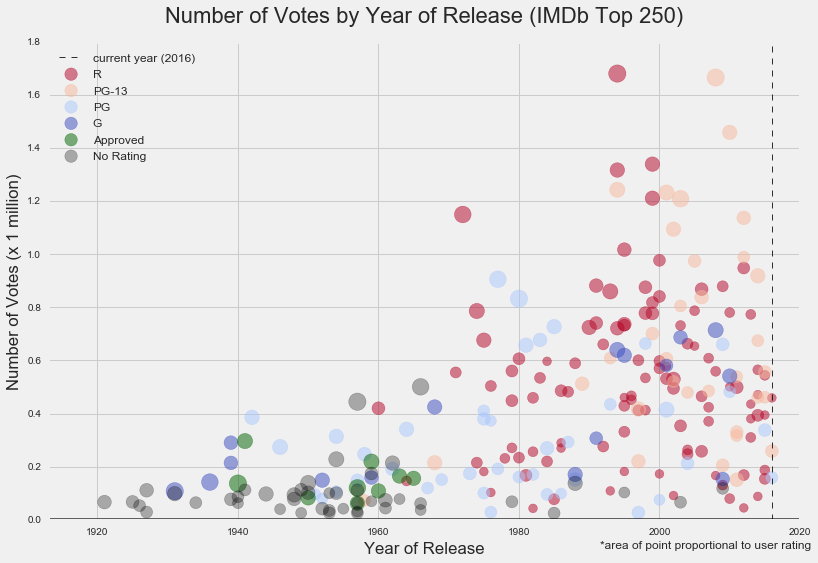

In [47]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

# subset dataframe by certification
top_R = top[top['cert'] == 'R']
top_NR = top[top['cert'] == 'Not Rated']
top_PG = top[top['cert'] == 'PG']
top_PG13 = top[top['cert'] == 'PG-13']
top_G = top[top['cert'] == 'G']
top_Approved = top[top['cert'] == 'Approved']

# assign colors to ranked certifications
cert = ['G', 'PG', 'PG-13', 'R']
cert_colors = []
for i in range(0, 256, 256/3):
    cert_colors.append(cm.coolwarm(i))
cert_dict = dict(zip(cert, cert_colors))

# set area of dot proportional-ish to rating
area = rating_area

# plot number of votes by year of release
plt.scatter(top_R['year'], top_R['num_votes']/1000000, color = cert_dict['R'], alpha = 0.5, s = area, label = 'R')
plt.scatter(top_PG13['year'], top_PG13['num_votes']/1000000, color = cert_dict['PG-13'], alpha = 0.5, s = area, \
            label = 'PG-13')
plt.scatter(top_PG['year'], top_PG['num_votes']/1000000, color = cert_dict['PG'], alpha = 0.5, s = area, label = 'PG')
plt.scatter(top_G['year'], top_G['num_votes']/1000000, color = cert_dict['G'], alpha = 0.5, s = area, label = 'G')
plt.scatter(top_Approved['year'], top_Approved['num_votes']/1000000, color = 'darkgreen', alpha = 0.5, s = area, \
            label = 'Approved')
plt.scatter(top_NR['year'], top_NR['num_votes']/1000000, color = 'black', alpha = 0.3, s = area, label = 'No Rating')

plt.title('Number of Votes by Year of Release (IMDb Top 250)', fontsize = 22, y = 1.03)

# add x-axis line and a line to show current year
plt.axhline(0, color='black', alpha = 0.6)
plt.axvline(2016, color='black', linestyle='dashed', linewidth=0.8, label = 'current year (2016)')

# y label
plt.ylabel('Number of Votes (x 1 million)')

# x label
plt.xlabel('Year of Release')

# set the figure boundaries
plt.xlim([min(top['year'])-8, 2020])
plt.ylim([0, 1.8])

plt.grid(True)
plt.legend(loc='upper left', fontsize = 12)
plt.annotate('*area of point proportional to user rating', (1,0), (-200, -20), \
             xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 12)
plt.show()

What's the red dot outlier in the 1970s up high?  The Godfather?  It is a truly exceptional movie!  From the 1990s onward, there does seem to be a drastic increase in the number of votes; this probably has to do with the invention of the internet, popularity increase of IMDb, etc.  It does not seem as though movies are objectively improving in quality at the same rate, however (if at all)... there are just a lot more people watching them and using the internet/social media.  The growth starts in the 1960s, though.  This was a turning point in American movies as the MPAA changed its audience viewing codes. 

In [48]:
top[(top['year'] < 1980) & (top['num_votes'] > 1000000)][['title', 'rating', 'year', 'num_votes']]

,title,rating,year,num_votes
1,The Godfather,9.2,1972,1149482


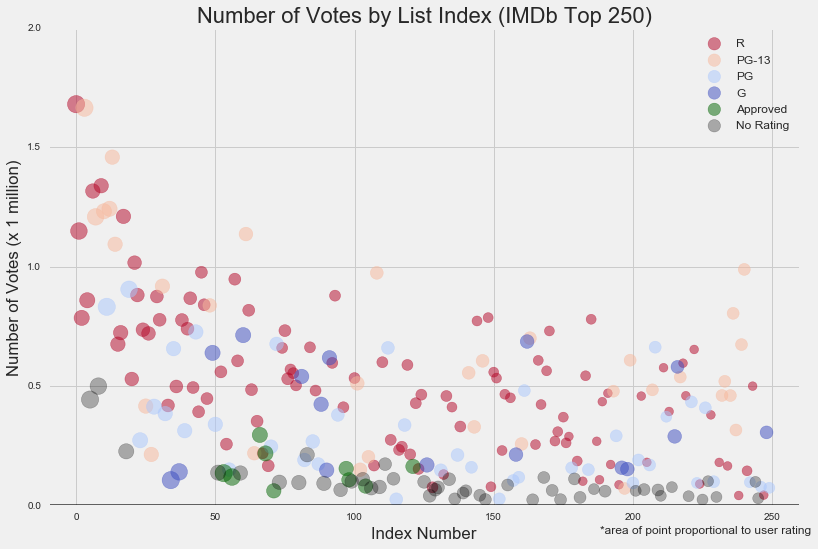

In [49]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

# subset dataframe by certification
top_R = top[top['cert'] == 'R']
top_NR = top[top['cert'] == 'Not Rated']
top_PG = top[top['cert'] == 'PG']
top_PG13 = top[top['cert'] == 'PG-13']
top_G = top[top['cert'] == 'G']
top_Approved = top[top['cert'] == 'Approved']

# assign colors to ranked certifications
cert = ['G', 'PG', 'PG-13', 'R']
cert_colors = []
for i in range(0, 256, 256/3):
    cert_colors.append(cm.coolwarm(i))
cert_dict = dict(zip(cert, cert_colors))

# set area of dot proportional-ish to rating
area = rating_area

# plot number of votes by year of release
plt.scatter(top_R.index, top_R['num_votes']/1000000, color = cert_dict['R'], alpha = 0.5, s = area, label = 'R')
plt.scatter(top_PG13.index, top_PG13['num_votes']/1000000, color = cert_dict['PG-13'], alpha = 0.5, s = area, \
            label = 'PG-13')
plt.scatter(top_PG.index, top_PG['num_votes']/1000000, color = cert_dict['PG'], alpha = 0.5, s = area, label = 'PG')
plt.scatter(top_G.index, top_G['num_votes']/1000000, color = cert_dict['G'], alpha = 0.5, s = area, label = 'G')
plt.scatter(top_Approved.index, top_Approved['num_votes']/1000000, color = 'darkgreen', alpha = 0.5, s = area, \
            label = 'Approved')
plt.scatter(top_NR.index, top_NR['num_votes']/1000000, color = 'black', alpha = 0.3, s = area, label = 'No Rating')

plt.title('Number of Votes by List Index (IMDb Top 250)', fontsize = 22)

# add x-axis line and a line to show current year
plt.axhline(0, color='black', alpha = 0.6)

# y label
plt.ylabel('Number of Votes (x 1 million)')

# x label
plt.xlabel('Index Number')

# set the figure boundaries
plt.xlim(-10, 260)
plt.ylim([0, 2.0])

plt.grid(True)
plt.legend(loc='upper right', fontsize = 12)
plt.annotate('*area of point proportional to user rating', (1,0), (-200, -20), \
             xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 12)
plt.show()

Again, from this plot it is clear that the index contains information (i.e., it's the site's rank of the movie).  Higher-ranked movies tend to have more votes; MPAA certifications are pretty uniformly distributed across the ranking; 'R' and 'PG-13' tend to get more votes than 'G' and 'PG', and certainly more than 'Not Rated' and 'Approved' (which was only given in the USA and no longer exists).  There also appears to be a positive correlation between lower index number (higher ranking) and number of votes.

OK!  Now let's scrape some additional data:

In [50]:
# URL = 'http://www.imdb.com/title/'
# paths = top['tconst']
# soup = []
# for i in paths:
#     time.sleep(1)
#     request = requests.get(URL + i + '/')
#     if str(request) != '<Response [200]>':
#         print URL + i + '/'
#     tiny_soup = BeautifulSoup(request.content, "lxml")
#     soup.append(tiny_soup)

# print 'done scraping!  pickle time.'
# cPickle.dump(soup, open('movie_soup2.p', 'wb')) 

HERE IS THE SOUP!  Not necessary to run the cell because scraped and constructed columns can also be loaded individually below.

In [51]:
# soup = cPickle.load(open('/Users/Rebecca/DSI-projects/projects/project-06/assets/movie_soup2.p', 'rb'))

In [52]:
# running_time = []
# for i in range(len(soup)):
#     times = []
#     for j in soup[i].find_all('time', itemprop = 'duration'):
#         times.append(j.text.encode('utf8'))
#     running_time.append(times[0])

# for i in range(len(running_time)):
#     split_time = []
#     clean_time = running_time[i].replace('\n                        ', '')
#     clean_time = clean_time.replace('min\n                    ', '')
#     split_time = clean_time.split('h ')
#     split_time[0] = split_time[0].replace('h\n                    ', '')
#     if len(split_time) == 1:
#         minutes = float(split_time[0]) * 60
#         running_time[i] = int(minutes) 
#     else:
#         minutes = float(split_time[0]) * 60 + float(split_time[1])
#         running_time[i] = int(minutes)
        
# run_time = pd.DataFrame(running_time, columns = ['run_time'])
# run_time.to_csv('/Users/Rebecca/DSI-projects/projects/project-06/assets/run_time.csv', index = False)

Load running time file and add as column to data frame:

In [53]:
run_time = pd.read_csv('/Users/Rebecca/DSI-projects/projects/project-06/assets/run_time.csv')
top['run_time'] = run_time

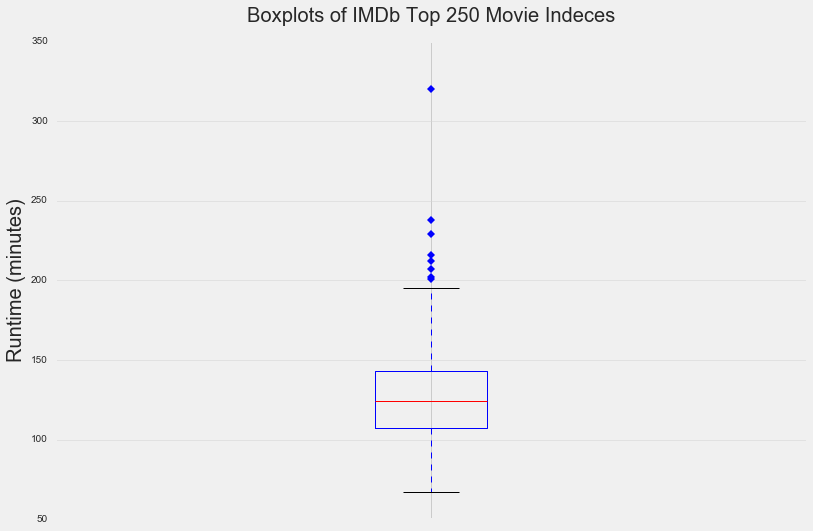

In [54]:
data = top['run_time']
plt.style.use('fivethirtyeight')
fig, ax1 = plt.subplots(figsize=(12, 8))
fig.canvas.set_window_title('Boxplots of Several IMDb Top 250 User Ratings')
plt.subplots_adjust(\
#                    left=0.075, right=0.95, top=0.9, bottom=0.25\
                   )

bp = plt.boxplot(data, 0, 'gD')

ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)

ax1.set_axisbelow(True)
ax1.set_title('Boxplots of IMDb Top 250 Movie Indeces', y =1.03)
ax1.set_xlabel('', fontsize = 20)
ax1.set_ylabel('Runtime (minutes)', fontsize = 20)

# Set the axes ranges and axes labels
numBoxes = 1
ax1.set_xlim(0.5, numBoxes + 0.5)
#ax1.set_ylim(425, 625)
xtickNames = plt.setp(ax1, xticklabels = '')
plt.setp(xtickNames, fontsize=16)

plt.show()

In [55]:
top['run_time'].describe()

count    250.000000
mean     128.628000
std       32.104398
min       67.000000
25%      107.000000
50%      124.000000
75%      143.000000
max      320.000000
Name: run_time, dtype: float64

In [56]:
top[top['run_time'] > 198][['title', 'year']].sort('year')

/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning:

sort(columns=....) is deprecated, use sort_values(by=.....)



,title,year
158,Gone with the Wind,1939
18,Seven Samurai,1954
196,Ben-Hur,1959
82,Lawrence of Arabia,1962
2,The Godfather: Part II,1974
67,Once Upon a Time in America,1984
7,The Lord of the Rings: The Return of the King,2003
247,Gangs of Wasseypur,2012


Wow, Gangs of Wasseypur is super long... let's keep it in for now, we may take it out later.  Other ones are not as far out from mean; we'll keep them.

In [57]:
# genre = []
# for i in range(len(soup)):
#     genres = []
#     for j in soup[i].find_all('span', itemprop = 'genre'):
#         genres.append(j.text.encode('utf8'))
#     genre.append(genres)

# for i in range(len(genre)):
#     genre[i] = str(genre[i])
    
# genre = pd.DataFrame(genre, columns = ['genre'])
# genre.to_csv('/Users/Rebecca/DSI-projects/projects/project-06/assets/genre.csv', index = False)

Load genre file and add as column to data frame:

In [58]:
genre = pd.read_csv('/Users/Rebecca/DSI-projects/projects/project-06/assets/genre.csv')
genre.columns = ['genre']
top['genre'] = genre

In [59]:
# release_info = []
# for i in range(len(soup)):
#     info = []
#     for j in soup[i].find_all('a', title = 'See more release dates'):
#         info.append(j.text.encode('utf8'))
#     release_info.append(info)

# month = []
# country = []
# for i in range(len(release_info)):
#     month_country = []
#     release_info[i] = str(release_info[i])
#     clean = release_info[i].replace(')\\n\\n\']', '')
#     split = clean.split(' ')
#     if len(split) == 4:
#         month.append(split[1])
#         split[3] = split[3].replace('(', '')
#         country.append(split[3])
#     else:
#         month.append(split)
#         country.append(split)

# all_months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', \
#              'November', 'December']

# top['month'] = month
# top['country'] = country
# for i in range(len(top)):
#     if top['month'][i] in all_months:
#         print '.',
#     else:
#         print '\n'
#         print top.loc[i][['title', 'month', 'country']]
#         print '\n'

Correct the ones that came through in different format and look up month for 'The Gold Rush' (thanks, Wikipedia!):

In [60]:
# top['month'][5] = 'April'
# top['country'][5] = 'USA'
# top['month'][56] = 'October'
# top['country'][56] = 'West Germany'
# top['month'][65] = 'November'
# top['country'][65] = 'South Korea'
# top['month'][129] = 'June'
# top['country'][129] = 'Germany'
# top['month'][209] = 'May'
# top['country'][209] = 'South Korea'
# top['month'][224] = 'December'
# top['country'][224] = 'Hong Kong'

In [61]:
# month = pd.DataFrame(top['month'], columns = ['month'])
# country = pd.DataFrame(top['country'], columns = ['country'])
# month.to_csv('/Users/Rebecca/DSI-projects/projects/project-06/assets/month.csv', index = False, encoding = 'utf-8')
# country.to_csv('/Users/Rebecca/DSI-projects/projects/project-06/assets/country.csv', index = False, encoding = 'utf-8')

Load month and country files and add as columns to data frame:

In [62]:
month = pd.read_csv('/Users/Rebecca/DSI-projects/projects/project-06/assets/month.csv')
country = pd.read_csv('/Users/Rebecca/DSI-projects/projects/project-06/assets/country.csv')
top['month'] = month
top['country'] = country
top['month'].value_counts()

December     29
February     24
June         23
March        23
January      21
October      21
May          20
November     20
August       19
July         18
September    17
April        15
Name: month, dtype: int64

Hey, I know!  Let's practice using dictionaries.  We'll make a bar plot of movie counts by month and put the bars in order of month (instead of order of count):

In [63]:
y = pd.DataFrame(top['month'].value_counts())
y.columns = ['count']
y['month'] = y.index
y = y.reset_index(drop = True)
order = range(12)
all_months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', \
              'November', 'December']
month_dict = dict(zip(all_months, order))
y['order'] = y['month'].apply(lambda x: month_dict[x])
y = y.sort('order')
del y['order']
y = y.set_index(y['month'], drop = False)
del y['month']

/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning:

sort(columns=....) is deprecated, use sort_values(by=.....)



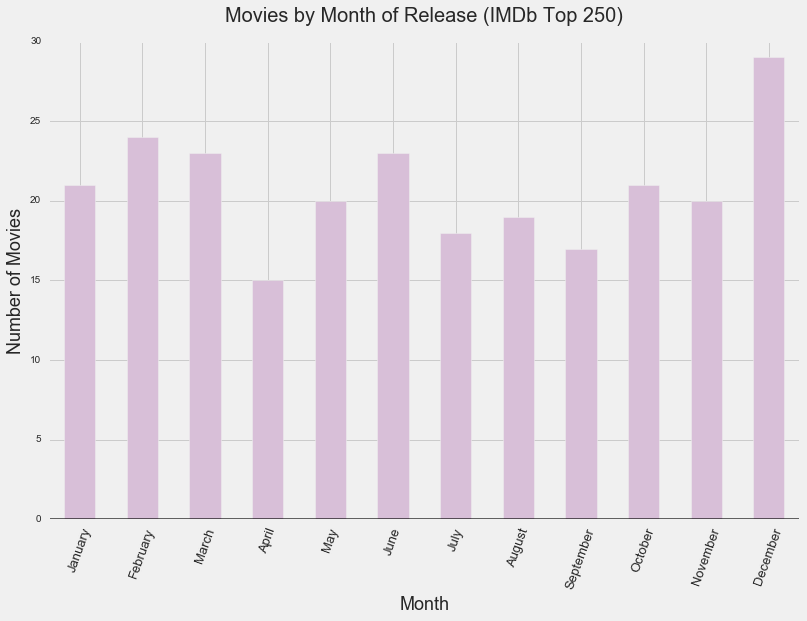

In [64]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

y['count'].plot.bar(color = 'thistle')

plt.title('Movies by Month of Release (IMDb Top 250)', fontsize = 20, y = 1.03)

# y label
plt.ylabel('Number of Movies', fontsize = 18)

# x label
plt.xlabel('Month', fontsize = 18)
plt.axhline(0, color='black', alpha = 0.6)
plt.xticks(rotation=70, fontsize = 13)
plt.show()

Nothing terribly non-intuive here; there are summer movies, there are winter/holiday movies, not a lot coming out in April and September.

Let's check out where non-USA, non-UK movies are from:

In [65]:
top[(top['country'] != 'USA') & (top['country'] != 'UK')][['title', 'country']].sort('country')

/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning:

sort(columns=....) is deprecated, use sort_values(by=.....)



,title,country
220,The Best Years of Our Lives,Argentina
195,Wild Tales,Argentina
168,Mary and Max,Australia
51,Sunset Blvd.,Australia
70,Vertigo,Brazil
234,Ip Man,China
107,The Hunt,Denmark
149,Incendies,France
152,The Message,France
98,The Apartment,France


A lot of these look weird... Hitchcock in Japan and Brazil?  Reservoir Dogs in France?  Maybe they're release locations?  Let's try to scrape country of origin separately and keep this as-is for now.

In [66]:
# origin = []
# for i in range(len(soup)):
#     country = []
#     for j in soup[i].find_all('a', href = re.compile('/country/')):
#         country.append(j.text.encode('utf8'))
#     if len(country) > 1:
#         mini_list = []
#         mini_list.append(country[0])
#         origin.append(mini_list)
#     else:
#         origin.append(country)

# origin = pd.DataFrame(origin)
# origin.to_csv('/Users/Rebecca/DSI-projects/projects/project-06/assets/origin.csv', index = False)

Load country of origin (we hope?) file and add as column to the data frame:

In [67]:
origin = pd.read_csv('/Users/Rebecca/DSI-projects/projects/project-06/assets/origin.csv')
top['origin'] = origin

Let's print all observations where 'country' does not match 'origin':

In [68]:
for i in range(len(top)):
    if top['country'][i] != top['origin'][i]:
        print top.loc[i][['title', 'country', 'origin']]
        print '\n'

title      The Good, the Bad and the Ugly
country                               USA
origin                              Italy
Name: 8, dtype: object


title      The Lord of the Rings: The Fellowship of the Ring
country                                                  USA
origin                                           New Zealand
Name: 10, dtype: object


title      Seven Samurai
country              USA
origin             Japan
Name: 18, dtype: object


title      City of God
country            USA
origin          Brazil
Name: 20, dtype: object


title      Life Is Beautiful
country                  USA
origin                 Italy
Name: 25, dtype: object


title      Léon: The Professional
country                       USA
origin                     France
Name: 26, dtype: object


title      Once Upon a Time in the West
country                             USA
origin                            Italy
Name: 27, dtype: object


title      Spirited Away
country              USA
origin 

Neither list is correct on every observation, so let's change 'country' to be the one we keep

In [69]:
# top['country'][206] = 'UK'
# top['country'][214] = 'Italy'
# top['country'][220] = 'USA'
# top['country'][225] = 'UK'
# top['country'][227] = 'France'
# top['country'][229] = 'USA'
# top['country'][230] = 'Italy'
# top['country'][234] = 'Hong Kong'
# top['country'][241] = 'Italy'
# top['country'][243] = 'UK'
# top['country'][245] = 'Japan'
# top['country'][247] = 'India'
# top['country'][249] = 'Hong Kong'
# top['country'][139] = 'USA'
# top['country'][140] = 'Sweden'
# top['country'][145] = 'USA'
# top['country'][147] = 'Japan'
# top['country'][149] = 'Canada'
# top['country'][152] = 'Lebanon'
# top['country'][154] = 'UK'
# top['country'][164] = 'Russia' # SOVIET UNION!
# top['country'][172] = 'UK'
# top['country'][181] = 'France' # and italy!
# top['country'][186] = 'France'
# top['country'][188] = 'Ireland'
# top['country'][190] = 'Sweden'
# top['country'][192] = 'Mexico'
# top['country'][196] = 'USA'
# top['country'][197] = 'USA'
# top['country'][204] = 'Russia' # SOVIET UNION!
# top['country'][104] = 'USA'
# top['country'][106] = 'Japan'
# top['country'][111] = 'USA'
# top['country'][115] = 'Iran'
# top['country'][117] = 'Germany'
# top['country'][123] = 'Ireland'
# top['country'][124] = 'Spanish'
# top['country'][127] = 'Japan'
# top['country'][129] = 'USA'
# top['country'][134] = 'Sweden'
# top['country'][137] = 'Japan'
# top['country'][70] = 'USA'
# top['country'][73] = 'Germany'
# top['country'][74] = 'USA'
# top['country'][76] = 'France'
# top['country'][87] = 'USA'
# top['country'][89] = 'Italy'
# top['country'][92] = 'UK'
# top['country'][97] = 'Italy'
# top['country'][98] = 'USA'
# top['country'][99] = 'Japan'
# top['country'][103] = 'Germany'
# top['country'][8] = 'Italy'
# top['country'][18] = 'Japan'
# top['country'][20] = 'Brazil'
# top['country'][25] = 'Italy'
# top['country'][26] = 'France'
# top['country'][27] = 'Italy'
# top['country'][28] = 'Japan'
# top['country'][39] = 'USA'
# top['country'][42] = 'France'
# top['country'][44] = 'USA'
# top['country'][51] = 'USA'
# top['country'][54] = 'Germany'
# top['country'][55] = 'Italy'
# top['country'][56] = 'USA'
# top['country'][68] = 'USA'
# top['country'][69] = 'Germany' # WEST Germany!

In [70]:
# country = pd.DataFrame(top['country'])
# country.to_csv('/Users/Rebecca/DSI-projects/projects/project-06/assets/country2.csv', index = False, \
#                encoding = 'utf-8')

In [71]:
country = pd.read_csv('/Users/Rebecca/DSI-projects/projects/project-06/assets/country2.csv')
top['country'] = country

In [72]:
del top['origin']

Get director name (only take first if more than one):

In [73]:
# director = []
# for i in range(len(soup)):
#     dirs = []
#     for j in soup[i].find_all('span', itemprop = 'director'):
#         for k in j.find_all('span', itemprop = 'name'):
#             dirs.append(k.text.encode('utf8'))
# # these two lines will print all directors' names for movies with more than one director listed
# #            if len(dirs) != 1:
# #                print dirs
#     if len(dirs) > 1:
#         mini_list = []
#         mini_list.append(dirs[0])
#         director.append(mini_list)
#     else:
#         director.append(dirs)
        
# len(director)

In [74]:
# director = pd.DataFrame(director)
# director.to_csv('/Users/Rebecca/DSI-projects/projects/project-06/assets/director.csv', index = False)

Note: some director observations had two names listed; only the first one was kept for the data set.  The second names tended to say "uncredited" after them and were never the main director.

In [75]:
director = pd.read_csv('/Users/Rebecca/DSI-projects/projects/project-06/assets/director.csv')
top['director'] = director

Surprise!  There are no female directors with more than two movies in the Top 250 list:

In [76]:
dir_count = pd.DataFrame(top['director'].value_counts())
dir_count.columns = ['count']
dir_count = dir_count[dir_count['count'] > 2]
dir_count

,count
Stanley Kubrick,7
Steven Spielberg,7
Alfred Hitchcock,7
Christopher Nolan,7
Martin Scorsese,7
Akira Kurosawa,6
Hayao Miyazaki,6
Sergio Leone,5
Charles Chaplin,5
Billy Wilder,5


We'll make dummy variables for these prolific directors later.

## Foreign vs Domestic:

From the MPAA certification-colored scatter plot, we can tell there is definitely something going on with 'Not Rated' and 'Approved' MPAA certifications with respect to year of release.  Let's investigate.

In [77]:
foreign_notNR = top[(top['cert'] != 'Not Rated') & (top['country'] != 'USA')]

foreign_NR = top[(top['cert'] == 'Not Rated') & (top['country'] != 'USA')]

domestic_notNR = top[(top['cert'] != 'Not Rated') & (top['country'] == 'USA')]

domestic_NR = top[(top['cert'] == 'Not Rated') & (top['country'] == 'USA')]

Most 'Not Rated' and 'Approved' movies in the list are pre-1970; after 1970, almost all of the 'Not Rated' movies are non-USA.  

In [78]:
x = float(len(foreign_notNR))/ (len(foreign_notNR) + len(foreign_NR))

print 'Proportion of non-\'Not Rated\' foreign films to \'Not Rated\' foreign films post-1970: %s' %round(x, 3)

Proportion of non-'Not Rated' foreign films to 'Not Rated' foreign films post-1970: 0.644


Additionally, all domestic films since 1970 are non-'Not Rated':

In [79]:
y = float(len(domestic_notNR[domestic_notNR['year'] > 1970]))/len(top[(top['country'] == 'USA') & (top['year'] > 1970)])

print 'Proportion of non-\'Not Rated\' domestic films to \'Not Rated\' domestic films post-1970: %s' %round(y, 3)

Proportion of non-'Not Rated' domestic films to 'Not Rated' domestic films post-1970: 1.0


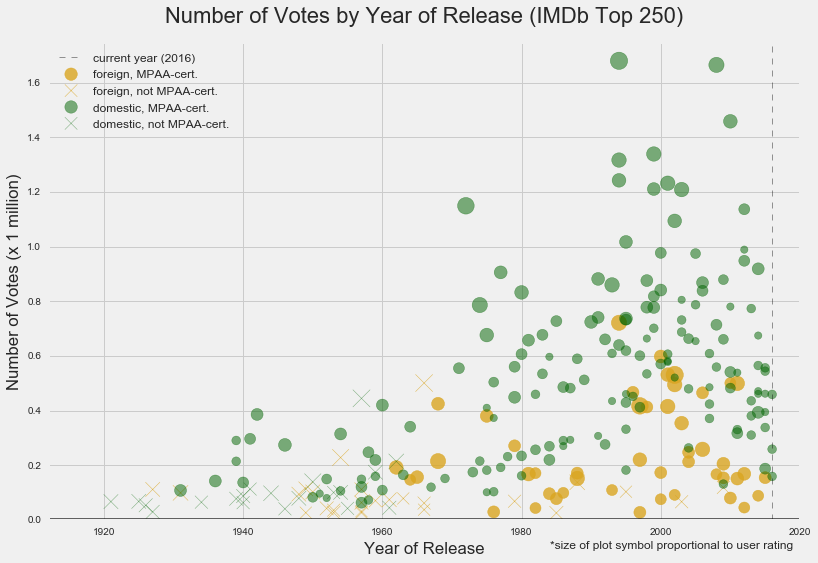

In [80]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')


# set area of dot proportional-ish to rating
area = rating_area

# plot number of votes by year of release
plt.scatter(foreign_notNR['year'], foreign_notNR['num_votes']/1000000, color = 'GoldenRod', \
            marker = 'o', alpha = 0.8, \
            s = area, \
            label = 'foreign, MPAA-cert.')
plt.scatter(foreign_NR['year'], foreign_NR['num_votes']/1000000, color = 'GoldenRod', \
            marker = 'x', alpha = 0.8, \
            s = area, \
            label = 'foreign, not MPAA-cert.')
plt.scatter(domestic_notNR['year'], domestic_notNR['num_votes']/1000000, color = 'darkgreen', \
            marker = 'o', alpha = 0.5, \
            s = area, \
            label = 'domestic, MPAA-cert.')
plt.scatter(domestic_NR['year'], domestic_NR['num_votes']/1000000, color = 'darkgreen', \
            marker = 'x', alpha = 0.5, \
            s = area, \
            label = 'domestic, not MPAA-cert.')

plt.title('Number of Votes by Year of Release (IMDb Top 250)', fontsize = 22, y = 1.03)

# add x-axis line and a line to show current year
plt.axhline(0, color='black', alpha = 0.6)
plt.axvline(2016, color='black', linestyle='dashed', linewidth=0.8, alpha = 0.5, label = 'current year (2016)')

# y label
plt.ylabel('Number of Votes (x 1 million)')

# x label
plt.xlabel('Year of Release')

# set the figure boundaries
plt.xlim([min(top['year'])-9, 2020])
plt.ylim([0, 1.75])

plt.grid(True)
plt.legend(loc='upper left', fontsize = 12)
plt.annotate('*size of plot symbol proportional to user rating', \
                (1,0), (-250, -20), xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 12)
plt.show()

What is the most recently released USA movie that had no MPAA rating ('cert')?

In [81]:
domestic_NR[['title', 'year']].sort('year', ascending = False).head(1)

/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning:

sort(columns=....) is deprecated, use sort_values(by=.....)



,title,year
83,To Kill a Mockingbird,1962


What's the highest-rated foreign movie?

In [82]:
top[top['country'] != 'USA'].sort('num_votes', ascending = False).head(1)[['title', 'year', 'country']]

/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning:

sort(columns=....) is deprecated, use sort_values(by=.....)



,title,year,country
26,Léon: The Professional,1994,France


Since the most recent 'Not Rated' domestic movie was 1962, let's check which/how many there have been since then:

In [83]:
top[(top['country'] != 'USA') & (top['cert'] == 'Not Rated') & (top['year'] > 1962)][['title', 'year', 'country']]\
                .sort('year', ascending = False).sort('year', ascending = False)

/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning:

sort(columns=....) is deprecated, use sort_values(by=.....)



,title,year,country
168,Mary and Max,2009,Australia
209,Memories of Murder,2003,South Korea
227,La Haine,1995,France
59,Grave of the Fireflies,1988,Japan
164,Come and See,1985,Russia
204,Stalker,1979,Russia
8,"The Good, the Bad and the Ugly",1966,Italy
190,Persona,1966,Sweden
230,The Battle of Algiers,1966,Italy
214,8½,1963,Italy


## Time to make dummies:

In [84]:
cv = CountVectorizer()
data = cv.fit_transform(top['genre']).todense()
columns = [c for c in cv.get_feature_names()]
dumbgenre = pd.DataFrame(data, columns=columns)

In [85]:
dumbgenre.columns

Index([u'action', u'adventure', u'animation', u'biography', u'comedy',
       u'crime', u'drama', u'family', u'fantasy', u'fi', u'film', u'history',
       u'horror', u'music', u'musical', u'mystery', u'noir', u'romance',
       u'sci', u'sport', u'thriller', u'war', u'western'],
      dtype='object')

Looks like strings 'sci fi' and 'film noir' got split up into separate dummy columns; let's delete one from each word pair so as not to be redundant in our columns:

In [86]:
del dumbgenre['fi']
del dumbgenre['film']
dumbgenre['scifi'] = dumbgenre['sci']
del dumbgenre['sci']

In [87]:
for column in dumbgenre.columns:
    x = dumbgenre[column].sum()
    print column, x

action 39
adventure 64
animation 19
biography 25
comedy 40
crime 55
drama 171
family 13
fantasy 20
history 14
horror 6
music 1
musical 1
mystery 30
noir 8
romance 21
sport 4
thriller 37
war 19
western 8
scifi 25


Should we consolidate music genre with musical genre?  There's only one movie in each genre in the top 250, so maybe we can...

In [88]:
dumbgenre[dumbgenre['music'] == 1]

,action,adventure,animation,biography,comedy,crime,drama,family,fantasy,history,...,music,musical,mystery,noir,romance,sport,thriller,war,western,scifi
44,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [89]:
top.loc[44]['title']

'Whiplash'

In [90]:
dumbgenre[dumbgenre['musical'] == 1]

,action,adventure,animation,biography,comedy,crime,drama,family,fantasy,history,...,music,musical,mystery,noir,romance,sport,thriller,war,western,scifi
90,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0


In [91]:
top.loc[90]['title']

"Singin' in the Rain"

'Whiplash' and 'Singin in the Rain'?  Welp, looks like we won't consolidate those two... on to more dummies!

In [92]:
dumbmonth = top[['month']]
dumbmonth = pd.get_dummies(dumbmonth)
dumbmonth.head(1)

,month_April,month_August,month_December,month_February,month_January,month_July,month_June,month_March,month_May,month_November,month_October,month_September
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [93]:
big_directors = dir_count.index
big_dir = []
for director in top['director']:
    if director in big_directors:
        big_dir.append(director)
    else:
        big_dir.append(0)
        
big_dir = pd.DataFrame(big_dir)
top['big_dir'] = big_dir

In [94]:
dumbdir = top[['big_dir']]
dumbdir = pd.get_dummies(dumbdir)
dumbdir.head(1)

,big_dir_0,big_dir_Akira Kurosawa,big_dir_Alfred Hitchcock,big_dir_Billy Wilder,big_dir_Charles Chaplin,big_dir_Christopher Nolan,big_dir_Clint Eastwood,big_dir_David Fincher,big_dir_Francis Ford Coppola,big_dir_Frank Capra,...,big_dir_Martin Scorsese,big_dir_Pete Docter,big_dir_Peter Jackson,big_dir_Quentin Tarantino,big_dir_Ridley Scott,big_dir_Sergio Leone,big_dir_Sidney Lumet,big_dir_Stanley Kubrick,big_dir_Steven Spielberg,big_dir_William Wyler
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [95]:
del dumbdir['big_dir_0']
del top['big_dir']

In [96]:
country_count = pd.DataFrame(top['country'].value_counts())
country_count.columns = ['count']
country_count = country_count[country_count['count'] > 2]
country_count

,count
USA,177
Japan,14
UK,12
Italy,10
France,7
Germany,5
Sweden,4
Hong Kong,3


In [97]:
big_country = country_count.index
big_countries = []
for country in top['country']:
    if country in big_country:
        big_countries.append(country)
    else:
        big_countries.append(0)
        
big_countries = pd.DataFrame(big_countries)
top['big_countries'] = big_countries

In [98]:
dumbcountry = top[['big_countries']]
dumbcountry = pd.get_dummies(dumbcountry)
dumbcountry.head(1)

,big_countries_0,big_countries_France,big_countries_Germany,big_countries_Hong Kong,big_countries_Italy,big_countries_Japan,big_countries_Sweden,big_countries_UK,big_countries_USA
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [99]:
del dumbcountry['big_countries_0']

In [100]:
# dumbUSA = []
# for country in top['country']:
#     if country == 'USA':
#         dumbUSA.append(1)
#     else:
#         dumbUSA.append(0)
# dumbUSA = pd.DataFrame(dumbUSA)
# dumbUSA.columns = ['USA']

In [101]:
dumbcert = top[['cert']]
dumbcert = pd.get_dummies(dumbcert)
dumbcert.head(1)

,cert_Approved,cert_G,cert_Not Rated,cert_PG,cert_PG-13,cert_R
0,0.0,0.0,0.0,0.0,0.0,1.0


In [103]:
big_top = pd.concat([top, dumbgenre, dumbmonth, dumbdir, dumbcountry, dumbcert\
#                     , dumbUSA\
                    ], axis = 1)
big_top.tail(1)

,tconst,title,rating,num_votes,year,top_year_color,cert,run_time,genre,month,...,big_countries_Japan,big_countries_Sweden,big_countries_UK,big_countries_USA,cert_Approved,cert_G,cert_Not Rated,cert_PG,cert_PG-13,cert_R
249,tt0118694,In the Mood for Love,8.1,75254,2000,"(0.845098039216, 0.0, 0.0, 1.0)",PG,98,"['Drama', 'Romance']",March,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [104]:
del big_top['tconst']
del big_top['title']
del big_top['top_year_color']
del big_top['cert']
del big_top['month']
del big_top['country']
del big_top['genre']
del big_top['director']
del big_top['big_countries']

In [105]:
big_top.head(1)

,rating,num_votes,year,run_time,action,adventure,animation,biography,comedy,crime,...,big_countries_Japan,big_countries_Sweden,big_countries_UK,big_countries_USA,cert_Approved,cert_G,cert_Not Rated,cert_PG,cert_PG-13,cert_R
0,9.3,1680129,1994,142,0,0,0,0,0,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


Let's take out those index outliers from the beginning of this notebook:

In [106]:
big_top = big_top.drop(big_top.index[[115, 152, 102, 105, 164, 174, 247, 225]])

Check if any columns sum to zero:

In [107]:
for i in big_top.columns:
    if big_top[i].sum() == 0:
        print '\n'
        print i
        print big_top[i].sum() 
    else:
        print '.',
        continue

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


## Let's plot!

In [108]:
len(big_top.columns)

73

In [109]:
np.any(np.isnan(big_top))

False

In [110]:
X = pd.DataFrame(big_top.ix[:, 1:len(big_top.columns)], columns = big_top.columns[1:len(big_top.columns)])
X_scaled = MinMaxScaler().fit_transform(X.astype(float))
X_scaled = pd.DataFrame(X_scaled, columns = X.columns[0:len(big_top.columns)])
len(X_scaled.columns)

72

In [111]:
y = big_top.ix[:, 0]

In [112]:
X_corr = pd.DataFrame(np.corrcoef(X_scaled.values.T), columns = X_scaled.columns)
X_corr.corr()

,num_votes,year,run_time,action,adventure,animation,biography,comedy,crime,drama,...,big_countries_Japan,big_countries_Sweden,big_countries_UK,big_countries_USA,cert_Approved,cert_G,cert_Not Rated,cert_PG,cert_PG-13,cert_R
num_votes,1.000000,0.783510,0.439746,0.638808,0.353782,-0.102913,0.067044,-0.265846,0.112730,-0.246838,...,-0.366112,-0.275604,-0.146441,0.587037,-0.279249,-0.144618,-0.731074,-0.181803,0.614776,0.423847
year,0.783510,1.000000,0.339029,0.447998,0.293116,0.120109,0.293323,-0.280318,-0.004226,-0.182955,...,-0.168721,-0.220371,0.000131,0.233084,-0.403367,-0.115686,-0.799088,-0.110699,0.468443,0.544086
run_time,0.439746,0.339029,1.000000,0.304258,-0.002890,-0.438009,0.429438,-0.571407,0.087954,0.353262,...,-0.192042,-0.127616,-0.094758,0.175923,-0.043759,-0.367569,-0.330296,-0.268416,0.348840,0.364969
action,0.638808,0.447998,0.304258,1.000000,0.617816,-0.030292,-0.124013,-0.207497,-0.238999,-0.477884,...,-0.075088,-0.158396,-0.164944,0.339198,-0.124335,-0.148116,-0.398115,0.002624,0.662017,-0.011995
adventure,0.353782,0.293116,-0.002890,0.617816,1.000000,0.578523,-0.241663,0.150158,-0.459864,-0.716161,...,0.214673,-0.167484,-0.001114,0.201036,-0.118429,0.364967,-0.316334,0.444722,0.486450,-0.452590
animation,-0.102913,0.120109,-0.438009,-0.030292,0.578523,1.000000,-0.234973,0.342188,-0.351303,-0.558175,...,0.579993,-0.065007,0.011267,-0.181790,-0.139756,0.635189,-0.065111,0.489867,-0.053540,-0.444230
biography,0.067044,0.293323,0.429438,-0.124013,-0.241663,-0.234973,1.000000,-0.194507,0.128972,0.405453,...,-0.177699,-0.076576,0.192081,-0.050480,-0.125891,-0.194511,-0.249827,-0.058597,-0.055759,0.375007
comedy,-0.265846,-0.280318,-0.571407,-0.207497,0.150158,0.342188,-0.194507,1.000000,-0.127291,-0.338724,...,0.020024,-0.059004,0.184943,-0.019256,0.099700,0.476508,0.187288,0.231077,-0.257320,-0.351094
crime,0.112730,-0.004226,0.087954,-0.238999,-0.459864,-0.351303,0.128972,-0.127291,1.000000,0.346470,...,-0.219675,-0.094261,-0.056060,0.150896,0.030274,-0.322404,0.057058,-0.314061,-0.222496,0.412552
drama,-0.246838,-0.182955,0.353262,-0.477884,-0.716161,-0.558175,0.405453,-0.338724,0.346470,1.000000,...,-0.143601,0.182835,-0.099991,-0.166009,0.108464,-0.373068,0.292387,-0.481937,-0.284563,0.375501


Set up plot parameters:

In [113]:
n = 242
plot_colors = []
for i in range(0, 256, 256/n):
    plot_colors.append(cm.Accent(i))

cv = KFold(len(X), n_folds = n, shuffle=False)


def do_plot(model, m=1):
    for fold, color in zip(cv, plot_colors):
        X_train = X.iloc[fold[0]]
        X_test  = X.iloc[fold[1]]
        y_train = y.iloc[fold[0]]
        y_test  = y.iloc[fold[1]]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
                
        plt.scatter(y_pred, y_test, color=color)
        plt.plot([8.0,9.5],[8.0,9.5], linewidth = 0.3)
        plt.text(9,9.5, "R^2: "+str(m), fontsize=20)
    return   

In [185]:
dt = DecisionTreeRegressor()

scores = cross_val_score(dt, X_scaled, y, cv=cv)
scores.mean()

0.19834710743801653

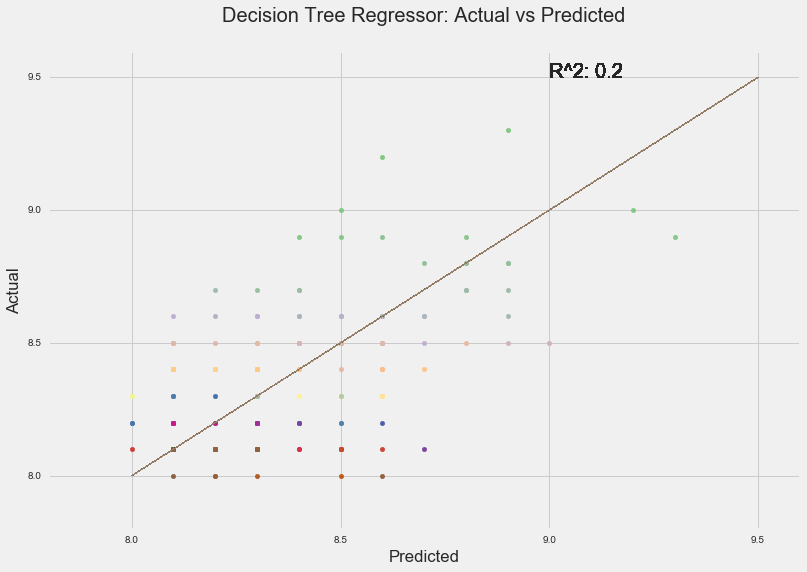

In [188]:
plt.figure(figsize=(12,8))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Decision Tree Regressor: Actual vs Predicted', fontsize = 20, y = 1.05)
plt.style.use('fivethirtyeight')


do_plot(dt, scores.mean().round(2))

First 20 features ranked by importance:

In [209]:
dt.fit(X_scaled, y)
print "Features sorted by their score:"
print sorted(zip(map(lambda x: round(x, 4), dt.feature_importances_), X_scaled.columns), 
             reverse=True)[0:5]

Features sorted by their score:
[(0.5688, 'num_votes'), (0.1315, 'year'), (0.0417, 'run_time'), (0.0254, 'big_countries_USA'), (0.0201, u'crime')]


In [163]:
rf = RandomForestRegressor(n_jobs = -1, n_estimators = 100)

scores = cross_val_score(rf, X_scaled, y, cv=cv)
scores.mean()

0.0

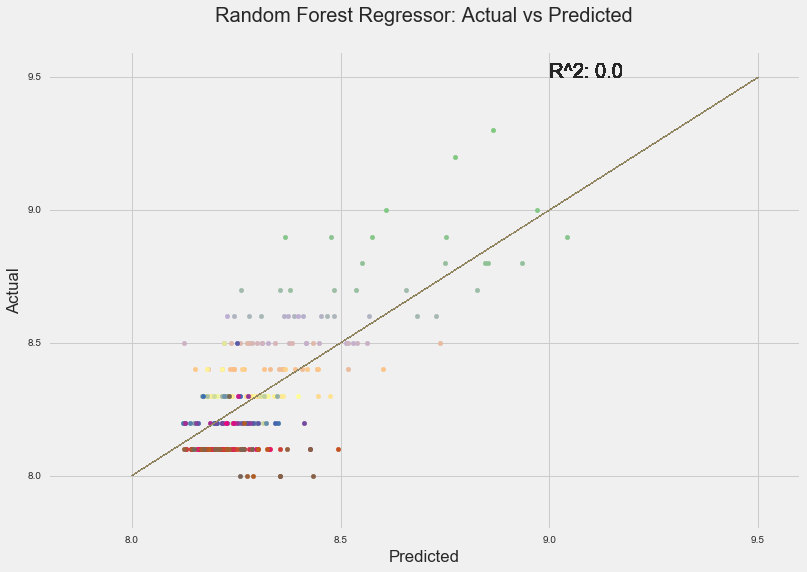

In [127]:
plt.figure(figsize=(12,8))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Regressor: Actual vs Predicted', fontsize = 20, y = 1.05)
plt.style.use('fivethirtyeight')

do_plot(rf, scores.mean().round(2))

In [216]:
rf.fit(X_scaled, y)
print "Features sorted by their score:"
print sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), X_scaled.columns), 
             reverse=True)[0:5]

Features sorted by their score:
[(0.5347, 'num_votes'), (0.1534, 'year'), (0.0581, 'run_time'), (0.0153, 'big_countries_USA'), (0.0116, 'cert_Not Rated')]


In [164]:
ab = AdaBoostRegressor(n_estimators = 100)

scores = cross_val_score(ab, X_scaled, y, cv=cv)
scores.mean()

0.0041322314049586778

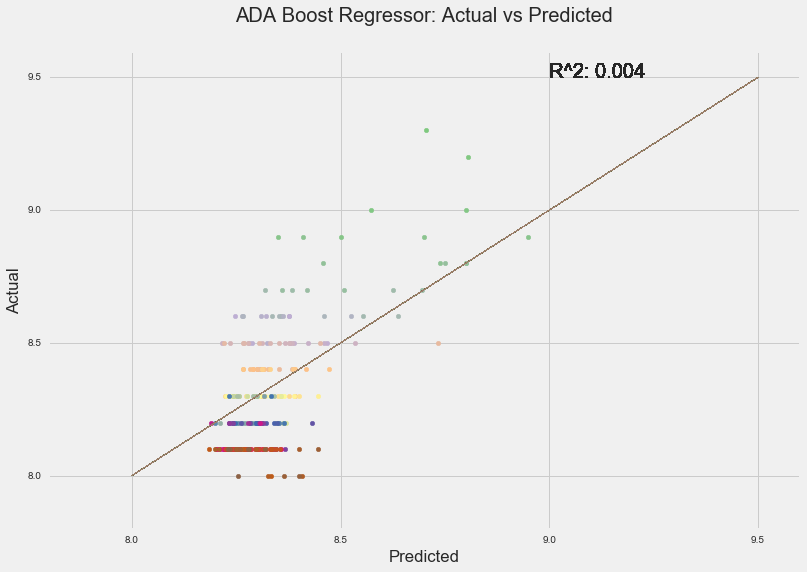

In [165]:
plt.figure(figsize=(12,8))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('ADA Boost Regressor: Actual vs Predicted', fontsize = 20, y = 1.05)
plt.style.use('fivethirtyeight')

do_plot(ab, scores.mean().round(3))

In [217]:
ab.fit(X_scaled, y)
print "Features sorted by their score:"
print sorted(zip(map(lambda x: round(x, 4), ab.feature_importances_), X_scaled.columns), 
             reverse=True)[0:5]

Features sorted by their score:
[(0.4757, 'num_votes'), (0.1701, 'year'), (0.1089, 'run_time'), (0.0421, 'cert_Not Rated'), (0.0272, 'month_December')]


In [166]:
gb = GradientBoostingRegressor(n_estimators = 100)

scores = cross_val_score(gb, X_scaled, y, cv=cv)
scores.mean()

0.0

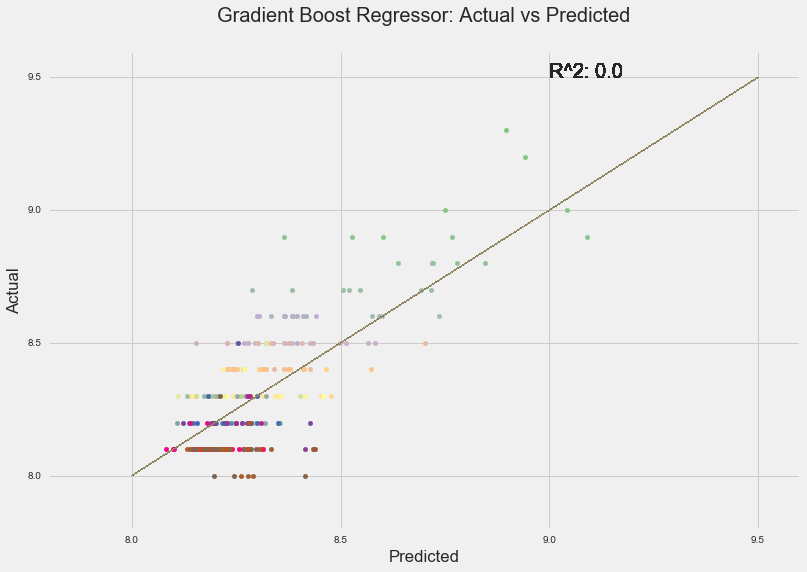

In [111]:
plt.figure(figsize=(12,8))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Gradient Boost Regressor: Actual vs Predicted', fontsize = 20, y = 1.05)
plt.style.use('fivethirtyeight')

do_plot(gb, scores.mean().round(2))

In [218]:
gb.fit(X_scaled, y)
print "Features sorted by their score:"
print sorted(zip(map(lambda x: round(x, 4), gb.feature_importances_), X_scaled.columns), 
             reverse=True)[0:5]

Features sorted by their score:
[(0.3081, 'num_votes'), (0.1365, 'year'), (0.0876, 'run_time'), (0.0437, 'big_countries_USA'), (0.0301, u'music')]


In [167]:
et = ExtraTreesRegressor(n_jobs = -1, n_estimators = 100)

scores = cross_val_score(et, X_scaled, y, cv=cv)
scores.mean()

0.0

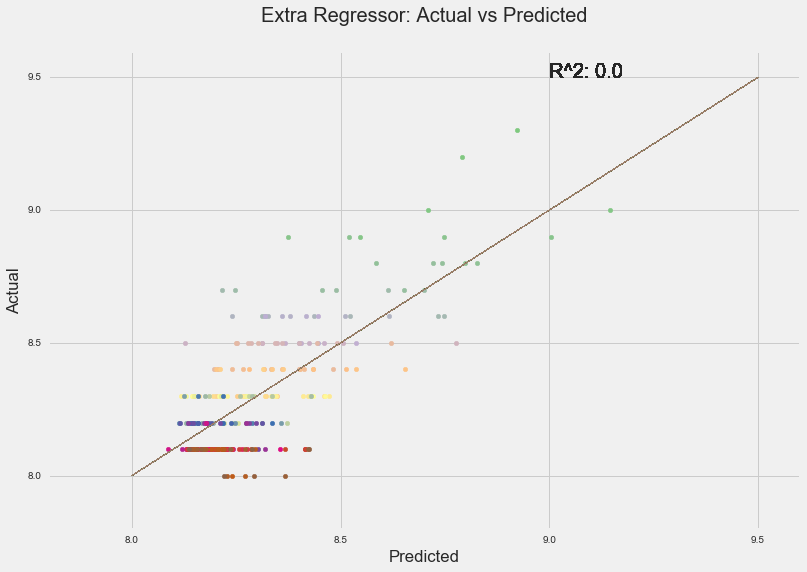

In [168]:
plt.figure(figsize=(12,8))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Extra Regressor: Actual vs Predicted', fontsize = 20, y = 1.05)
plt.style.use('fivethirtyeight')

do_plot(et, scores.mean().round(2))

In [219]:
et.fit(X_scaled, y)
print "Features sorted by their score:"
print sorted(zip(map(lambda x: round(x, 4), et.feature_importances_), X_scaled.columns), 
             reverse=True)[0:5]

Features sorted by their score:
[(0.4135, 'num_votes'), (0.0788, 'year'), (0.0488, 'big_dir_Francis Ford Coppola'), (0.0369, 'cert_Not Rated'), (0.0289, 'run_time')]


In [169]:
bagger = BaggingRegressor(DecisionTreeRegressor())

scores = cross_val_score(bagger, X_scaled, y, cv=cv)
scores.mean()

0.0041322314049586778

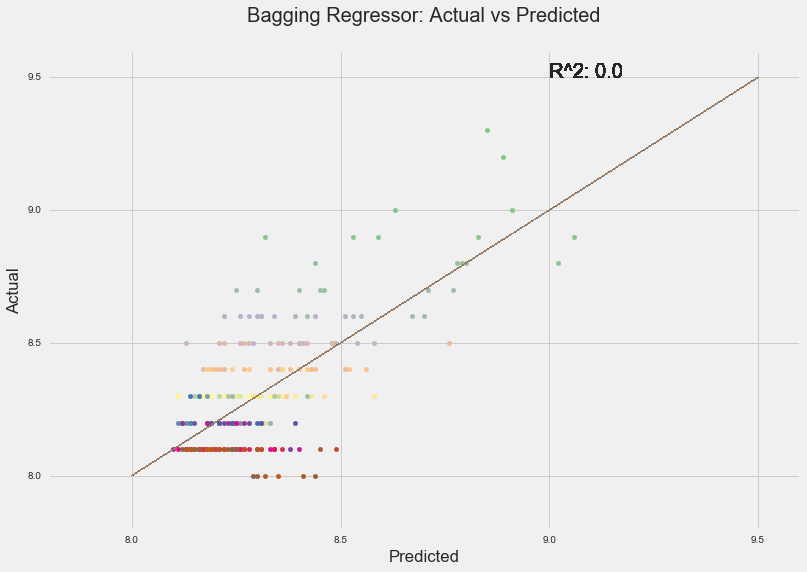

In [170]:
plt.figure(figsize=(12,8))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Bagging Regressor: Actual vs Predicted', fontsize = 20, y = 1.05)
plt.style.use('fivethirtyeight')

do_plot(bagger, scores.mean().round(2))

In [222]:
def get_score(model, name):
    score = cross_val_score(model, X_scaled, y, cv = cv, n_jobs = -1)
    print('{} Score:\t{:0.3} ± {:0.3}'.format(name, score.mean().round(3), score.std().round(3)))
    
pairs = {
    'Decision Tree' : dt,
    'Bagging' : bagger,
    'Random Forest' : rf,
    'Extra Trees' : et,
    'Ada Booster' : ab,
    'Gradient Booster' : gb
}

for key in list(pairs.keys()):
    get_score(pairs[key], key)

Bagging Score:	0.017 ± 0.127
Extra Trees Score:	0.0 ± 0.0
Decision Tree Score:	0.19 ± 0.392
Gradient Booster Score:	0.0 ± 0.0
Ada Booster Score:	0.004 ± 0.064
Random Forest Score:	0.0 ± 0.0


Now let's only consider movies post-1962, since right around then seems to have been a turning point in terms of user rating behavior on IMDb:

In [114]:
new_top = big_top[big_top['year'] > 1962]

/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



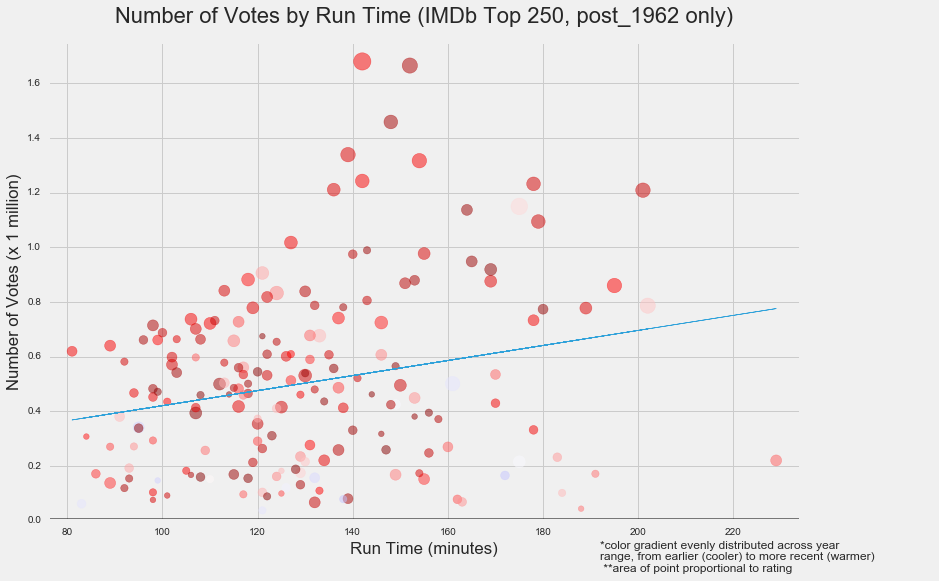

In [115]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

top_year_color = []
count = 0
for i in new_top['year']:
    lil_color = cm.seismic((i-1920)*256/(2017-1920))
    top_year_color.append(lil_color)
    
new_top['top_year_color'] = top_year_color

plt.scatter(new_top['run_time'], new_top['num_votes']/1000000, color = new_top['top_year_color'], alpha = 0.5, s = area)

plt.title('Number of Votes by Run Time (IMDb Top 250, post_1962 only)', fontsize = 22, y = 1.03)
plt.axhline(0, color='black', alpha = 0.5)

# y label
plt.ylabel('Number of Votes (x 1 million)')

# x label
plt.xlabel('Run Time (minutes)')

# set the figure boundaries
plt.xlim([min(new_top['run_time'])-5, max(new_top['run_time'])+5])
plt.ylim([0, 1.75])
plt.grid(True)
plt.annotate('*color gradient evenly distributed across year \nrange, from earlier (cooler) to more recent (warmer)\
                 \n **area of point proportional to rating', (1,0), (-200, -20), \
                     xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 12)

m, b = np.polyfit(new_top['run_time'], new_top['num_votes']/1000000, 1)

plt.plot(new_top['run_time'], m*new_top['run_time'] + b, '-', linewidth = 0.7)

plt.show()

This scatter plot seems to suggest a positive correlation between run time and number of votes.  Let's check out that outlier in the bottom right: 

Check if any columns sum to zero since we took out 1962.  If so, remove them:

In [116]:
for i in new_top.columns:
    if new_top[i].sum() == 0:
        print '\n'
        print i
    else:
        print '.',

. . . . . . . . . . . . . . . . 

musical
. 

noir
. . . . . . . . . . . . . . . . . . . 

big_dir_Alfred Hitchcock


big_dir_Billy Wilder


big_dir_Charles Chaplin
. . . . 

big_dir_Frank Capra
. . . . . . . . . . . . 

big_dir_William Wyler
. . . . . . . . . . . . . . .


In [117]:
del new_top['musical']
del new_top['noir']
del new_top['big_dir_Alfred Hitchcock']
del new_top['big_dir_Billy Wilder']
del new_top['big_dir_Charles Chaplin']
del new_top['big_dir_Frank Capra']
del new_top['big_dir_William Wyler']
del new_top['top_year_color']

In [118]:
X_post62 = pd.DataFrame(new_top.ix[:, 1:len(new_top.columns)], \
                        columns = new_top.columns[1:len(new_top.columns)])
Xs = MinMaxScaler().fit_transform(X_post62.astype(float))
Xs = pd.DataFrame(Xs, columns = X_post62.columns[0:len(new_top.columns)])
y_new = new_top.ix[:,0]
len(Xs.columns)

65

In [119]:
Xs.head(1)

,num_votes,year,run_time,action,adventure,animation,biography,comedy,crime,drama,...,big_countries_Japan,big_countries_Sweden,big_countries_UK,big_countries_USA,cert_Approved,cert_G,cert_Not Rated,cert_PG,cert_PG-13,cert_R
0,1.0,0.584906,0.412162,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [121]:
n = len(Xs)
plot_colors = []
for i in range(0, 256, 256/n):
    plot_colors.append(cm.Accent(i))

cv = KFold(len(X_post62), n_folds = n, shuffle=False)


def do_plot(model, m=1):
    for fold, color in zip(cv, plot_colors):
        X_train = X.iloc[fold[0]]
        X_test  = X.iloc[fold[1]]
        y_train = y.iloc[fold[0]]
        y_test  = y.iloc[fold[1]]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
                
        plt.scatter(y_pred, y_test, color=color)
        plt.plot([8.0,9.5],[8.0,9.5], linewidth = 0.3)
        plt.text(9,9.5, "R^2: "+str(m), fontsize=20)
    return  

In [245]:
dt = DecisionTreeRegressor()

scores = cross_val_score(dt, Xs, y_new, cv=cv)
scores.mean()

0.14130434782608695

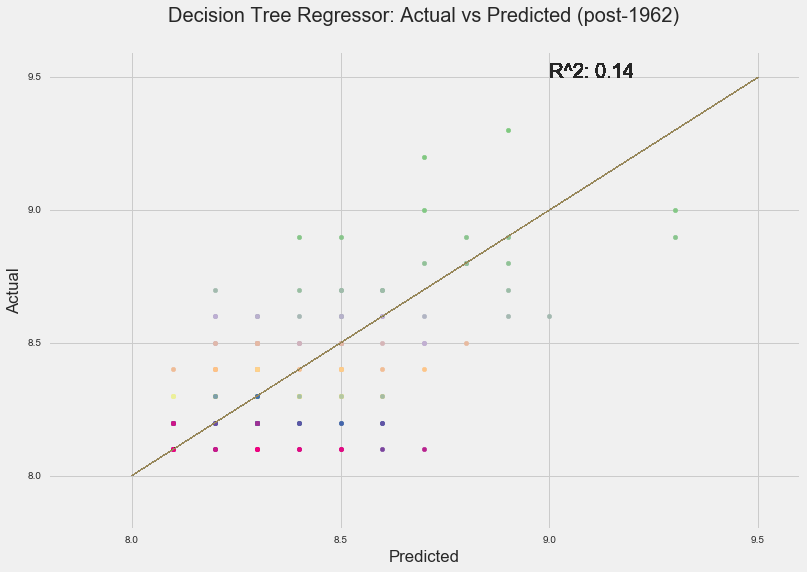

In [246]:
plt.figure(figsize=(12,8))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Decision Tree Regressor: Actual vs Predicted (post-1962)', fontsize = 20, y = 1.05)
plt.style.use('fivethirtyeight')

do_plot(dt, scores.mean().round(2))

In [247]:
dt.fit(Xs, y_new)
print "Features sorted by their score:"
print sorted(zip(map(lambda x: round(x, 4), dt.feature_importances_), Xs.columns), 
             reverse=True)[0:5]

Features sorted by their score:
[(0.5996, 'num_votes'), (0.1444, 'year'), (0.0518, 'run_time'), (0.0283, 'big_countries_USA'), (0.0237, 'big_countries_UK')]


In [236]:
rf = RandomForestRegressor(n_jobs = -1, n_estimators = 100)

scores = cross_val_score(rf, Xs, y_new, cv=cv)
scores.mean()

0.0

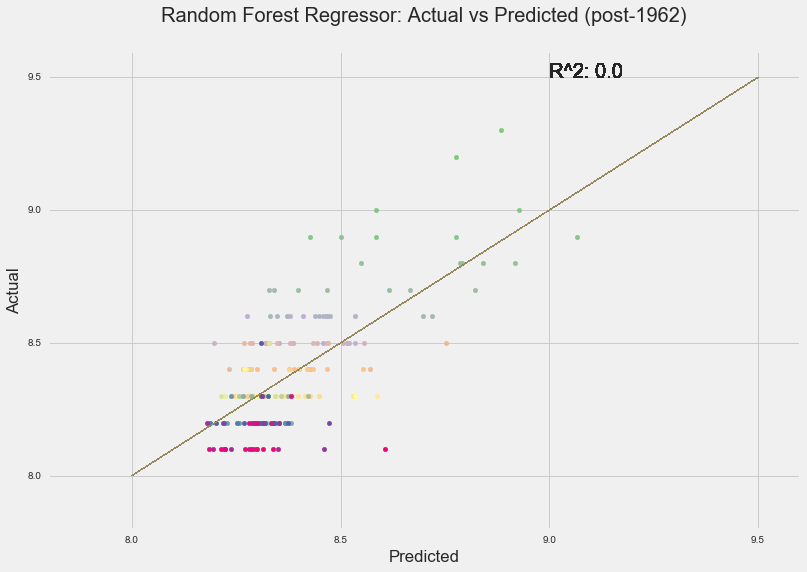

In [188]:
plt.figure(figsize=(12,8))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Regressor: Actual vs Predicted (post-1962)', fontsize = 20, y = 1.05)
plt.style.use('fivethirtyeight')

do_plot(rf, scores.mean().round(2))

In [238]:
rf.fit(Xs, y_new)
print "Features sorted by their score:"
print sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), Xs.columns), 
             reverse=True)[0:5]

Features sorted by their score:
[(0.5895, 'num_votes'), (0.1136, 'year'), (0.0595, 'run_time'), (0.0159, 'big_countries_USA'), (0.0145, 'big_countries_France')]


In [248]:
et = ExtraTreesRegressor(n_jobs = -1, n_estimators = 100)

scores = cross_val_score(et, Xs, y_new, cv=cv)
scores.mean()

0.0

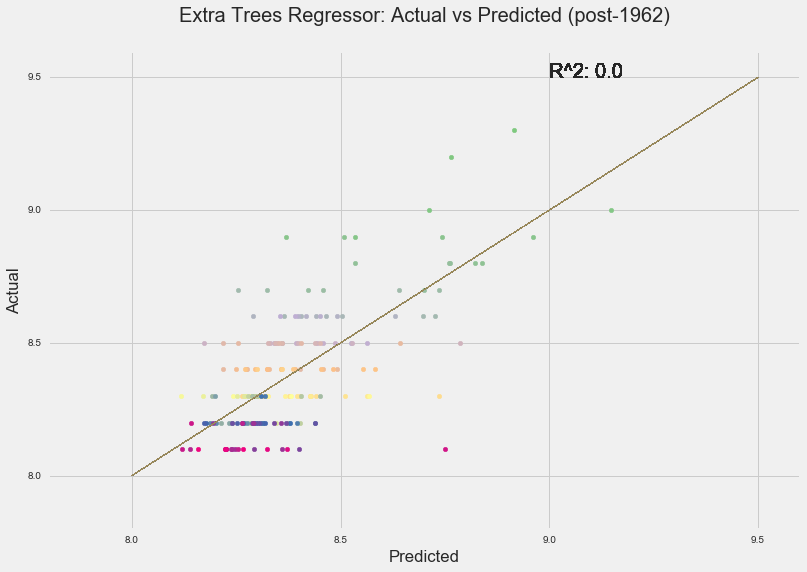

In [249]:
plt.figure(figsize=(12,8))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Extra Trees Regressor: Actual vs Predicted (post-1962)', fontsize = 20, y = 1.05)
plt.style.use('fivethirtyeight')

do_plot(et, scores.mean().round(2))

In [250]:
et.fit(Xs, y_new)
print "Features sorted by their score:"
print sorted(zip(map(lambda x: round(x, 4), et.feature_importances_), Xs.columns), 
             reverse=True)[0:5]

Features sorted by their score:
[(0.4733, 'num_votes'), (0.0685, 'year'), (0.0532, 'big_dir_Francis Ford Coppola'), (0.0276, 'run_time'), (0.0221, u'crime')]


In [252]:
ab = AdaBoostRegressor(n_estimators = 100)

scores = cross_val_score(ab, Xs, y_new, cv=cv)
scores.mean()

0.005434782608695652

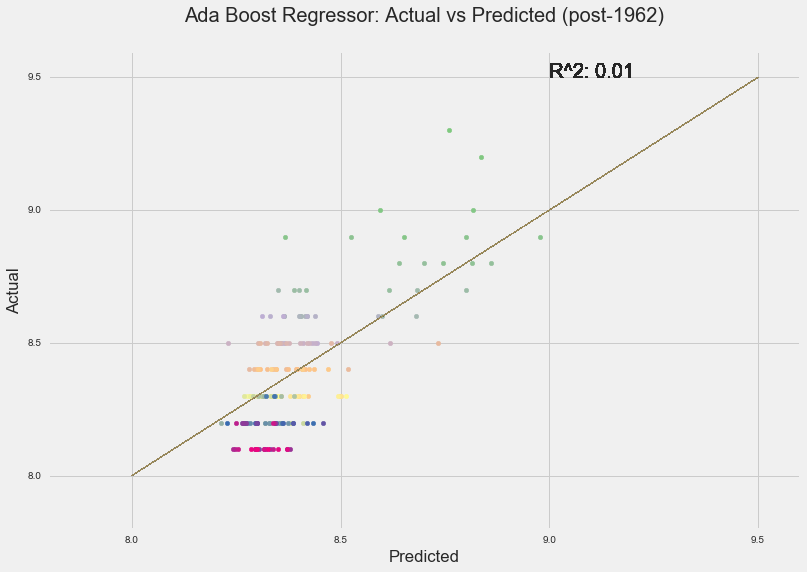

In [253]:
plt.figure(figsize=(12,8))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Ada Boost Regressor: Actual vs Predicted (post-1962)', fontsize = 20, y = 1.05)
plt.style.use('fivethirtyeight')

do_plot(ab, scores.mean().round(2))

In [254]:
ab.fit(Xs, y_new)
print "Features sorted by their score:"
print sorted(zip(map(lambda x: round(x, 4), ab.feature_importances_), Xs.columns), 
             reverse=True)[0:5]

Features sorted by their score:
[(0.4934, 'num_votes'), (0.1631, 'run_time'), (0.1381, 'year'), (0.0414, 'big_countries_USA'), (0.028, 'month_December')]


In [122]:
gb = GradientBoostingRegressor(n_estimators = 100)

scores = cross_val_score(gb, Xs, y_new, cv=cv)
scores.mean()

0.0

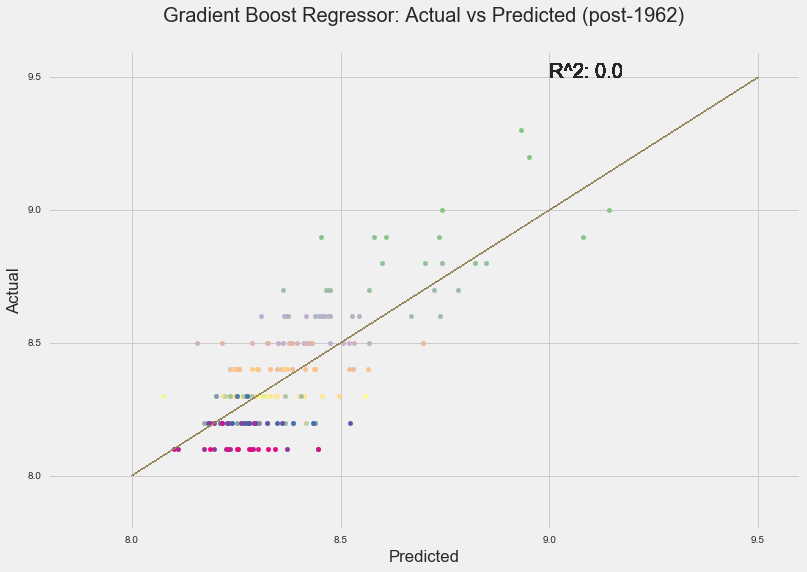

In [123]:
plt.figure(figsize=(12,8))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Gradient Boost Regressor: Actual vs Predicted (post-1962)', fontsize = 20, y = 1.05)
plt.style.use('fivethirtyeight')

do_plot(gb, scores.mean().round(2))

In [124]:
gb.fit(Xs, y_new)
print "Features sorted by their score:"
print sorted(zip(map(lambda x: round(x, 4), gb.feature_importances_), Xs.columns), 
             reverse=True)[0:5]

Features sorted by their score:
[(0.2854, 'num_votes'), (0.134, 'year'), (0.104, 'run_time'), (0.0427, 'big_countries_USA'), (0.0359, u'music')]


In [ ]:
def get_score(model, name):
    score = cross_val_score(model, Xs, y_new, cv = cv, n_jobs = -1)
    print('{} Score:\t{:0.3} ± {:0.3}'.format(name, score.mean().round(3), score.std().round(3)))
    
pairs = {
    'Decision Tree' : dt,
    'Bagging' : bagger,
    'Random Forest' : rf,
    'Extra Trees' : et,
    'Ada Booster' : ab,
    'Gradient Booster' : gb
}

for key in list(pairs.keys()):
    get_score(pairs[key], key)

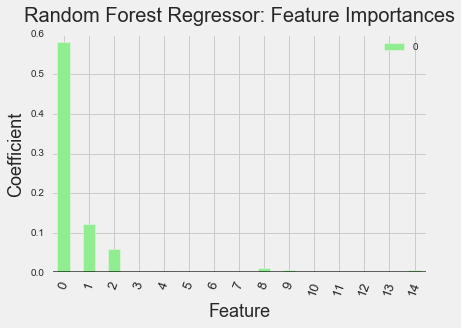

In [192]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

z = pd.DataFrame(rf.feature_importances_[0:15])

z.plot.bar(color = 'lightgreen')

plt.title('Random Forest Regressor: Feature Importances', fontsize = 20, y = 1.03)

# y label
plt.ylabel('Coefficient', fontsize = 18)

# x label
plt.xlabel('Feature', fontsize = 18)
plt.axhline(0, color='black', alpha = 0.6)
plt.xticks(rotation=70, fontsize = 13)
plt.show()

As we can see from changes in the histograms of feature importance, once we remove pre-1962 movies from the data set, vote count becomes more important, while year becomes less so.  This makes sense intuitively, since we know that older movies have fewer votes on average and the number of votes for newer movies is increasingly spread out.  Refer to the Rating vs Number of Votes plot (blue-to-red dots, by year) to illustrate this point; if you take out all the blue points, the variance in remaining dots becomes larger (i.e., number of votes is an even more significant predictive feature).  Along these same lines, once the older movies are removed, year of release is a less significant feature.

Let's do a classifier now; classifications will be encoded by tenths place from 8.0 to 9.3:

In [269]:
encoder = LabelEncoder()
fit = encoder.fit(y_new)
y_cats = encoder.transform(y_new)

In [332]:
X_train, X_test, y_train, y_test = train_test_split(Xs, y_cats, test_size=0.33, random_state=42)

rfc = RandomForestClassifier(n_jobs = -1, n_estimators = 100)

y_pred = rfc.fit(X_train, y_train).predict(X_test)

pred1 = rfc.predict_proba(X_train).T[1]
pred1

array([ 0.86,  0.01,  0.05,  0.  ,  0.95,  0.11,  0.01,  0.11,  0.08,
        0.89,  0.11,  0.03,  0.07,  0.86,  0.  ,  0.01,  0.08,  0.03,
        0.04,  0.95,  0.91,  0.89,  0.03,  0.02,  0.06,  0.93,  0.9 ,
        0.01,  0.04,  0.89,  0.  ,  0.01,  0.  ,  0.03,  0.03,  0.13,
        0.07,  0.91,  0.93,  0.07,  0.04,  0.94,  0.04,  0.05,  0.04,
        0.02,  0.  ,  0.02,  0.06,  0.88,  0.87,  0.  ,  0.  ,  0.84,
        0.04,  0.  ,  0.03,  0.01,  0.03,  0.9 ,  0.85,  0.01,  0.04,
        0.96,  0.04,  0.02,  0.09,  0.93,  0.89,  0.9 ,  0.01,  0.06,
        0.03,  0.06,  0.06,  0.04,  0.01,  0.89,  0.93,  0.05,  0.  ,
        0.02,  0.  ,  0.92,  0.93,  0.02,  0.03,  0.89,  0.92,  0.94,
        0.91,  0.04,  0.03,  0.03,  0.05,  0.9 ,  0.04,  0.05,  0.05,
        0.03,  0.03,  0.98,  0.94,  0.97,  0.01,  0.96,  0.91,  0.  ,
        0.04,  0.84,  0.9 ,  0.93,  0.04,  0.02,  0.1 ,  0.03,  0.03,
        0.04,  0.99,  0.03,  0.04,  0.05,  0.01,  0.  ,  0.9 ,  0.09])

In [333]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 18,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  4,  3,  0,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  3,  4,  2,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  3,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  3,  4,  0,  1,  0,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  1,  0,  0,  1,  1,  0,  0,  1,  0,  0,  0],
       [ 0,  0,  1,  1,  0,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])

In [334]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels = ['8.1', '8.2', '8.3', '8.4',\
                                                    '8.5', '8.6', '8.7', '8.8', '8.9', '9.0', '9.1', '9.2', '9.3']):
    
    plt.figure(figsize=(12,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)
        
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
    width, height = cm.shape
    
    for x in xrange(width):
        for y in xrange(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center',
                        color = 'white',
                        fontsize=18).set_path_effects([path_effects.Stroke(linewidth=1, foreground='black'),
                                                       path_effects.Normal()]) #The last line here adds a text outline
    return

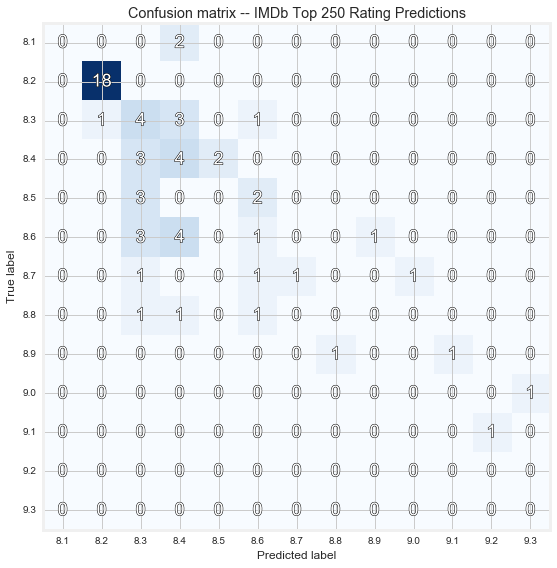

In [335]:
plot_confusion_matrix(cm, title='Confusion matrix -- IMDb Top 250 Rating Predictions')

In [340]:
roc = roc_curve(y_test, y_pred, pos_label = 1)
roc

(array([ 0.        ,  0.02222222,  0.15555556,  0.28888889,  0.33333333,
         0.64444444,  0.97777778,  1.        ]),
 array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([13, 12,  6,  5,  4,  3,  2,  1]))

In [341]:
def getROCcurve(roc, title='ROC Curve', xlabel ='% of False Positives', ylabel = '% of True Positives'):
    fpr, tpr, thresholds = roc
    
    fig,ax = plt.subplots()
    ax.plot(fpr, tpr, label='ROC Curve')

    fig.set_size_inches(7, 6, forward=True)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(loc='best')
    plt.plot([0, 1], [0, 1], 'k--', linewidth = 0.4, color = 'magenta')
    return

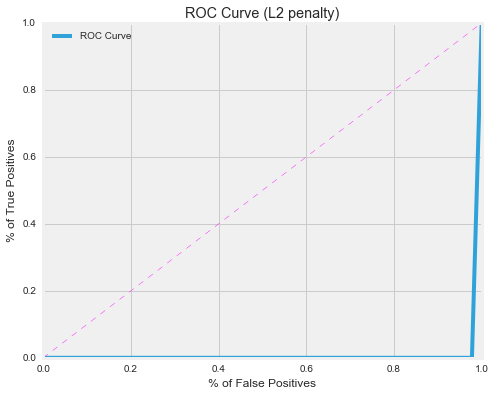

In [342]:
getROCcurve(roc, title='ROC Curve (L2 penalty)', xlabel ='% of False Positives', ylabel = '% of True Positives')

In [351]:
top.columns

Index([u'tconst', u'title', u'rating', u'num_votes', u'year', u'cert',
       u'run_time', u'genre', u'month', u'country', u'director',
       u'big_countries', u'top_year_color'],
      dtype='object')